In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/MyDrive/

# %cd /content/gdrive/MyDrive/SMAI/project
# !pwd

### Forward-mode Automatic Differentiation (AD) 
Let $f: \mathbb{R}^m \rightarrow \mathbb{R}^n$. The Jacobian of $f$, denoted by $J_f$, is a matrix of size $n \times m$. Forward-mode AD computes the matrix-vector product $J_f \boldsymbol{v}$, where $\boldsymbol{v} \in \mathbb{R}^m$. It is defined as the directional gradient along $\boldsymbol{v}$ evaluated at $x$:

$$ J_f \boldsymbol{v} \triangleq lim_{\delta \rightarrow 0} \dfrac{f(\boldsymbol{x} + \delta \boldsymbol{v}) - f(\boldsymbol{x})}{\delta} $$

In other words, forward-mode AD calculates the Jacobian-vector product of a function using a single forward pass through the computation graph, and is useful for computing gradients of high-dimensional functions.


### Weight-perturbed forward gradient:


$$g_w(w_{ij}) = (\sum_{i'j'} \nabla w_{i'j'} v_{i'j'}) v_{ij} $$

### Activity-perturbed forward gradient:


$$ g_a(w_{ij}) = x_i (\sum_{j'} \nabla z_{j'} u_{j'})u_{j} $$


### Implementation

- `jax.jvp` for computing the product of the Jacobian matrix and a vector
- `jax.grad`: used to compute the gradient of a given loss function with respect to some or all of its inputs, using automatic differentiation
- `jnp.sum`: used to compute the sum of all elements of a given tensor, which is used in various loss functions
- `jnp.mean`: used to compute the mean of all elements of a given tensor, which is used in various loss functions.
- `jnp.einsum`: used to compute the dot product of two tensors along a specific set of axes, which is used to implement the linear layers in the model
- `depthwise_conv`: used to perform a depthwise convolution of a given tensor with a set of filters, which is used to implement the convolutions in the model
- `spatial_avg_group_linear_custom_vjp`: used to perform a custom vector-Jacobian product (VJP) for the spatial average group linear layer in the model, which is necessary for computing the gradients of the loss function with respect to the weights and biases of the layer
- `spatial_avg_group_linear_cross_entropy_custom_vjp`: used to perform a custom VJP for the spatial average group linear layer when using the fused cross-entropy loss function, which is necessary for computing the gradients of the loss function with respect to the weights and biases of the layer
- `normalize`: used to normalize the activations of the model, either across channels or across spatial dimensions, which is used for activation regularization

### Imports and Installs

In [2]:
# installs 
!pip install einops
!pip install clu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=9b8b820465fdc9c855688446093984a574296e28aa6ab0363e583855562d0ab7
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml-collections


In [3]:
# imports 

import jax
jax.config.update("jax_platform_name", "gpu") 

import numpy as np
import einops
import flax
import jax.numpy as jnp
import numpy.random as npr
import math

import os
import pickle as pkl
import tensorflow as tf
import time
import optax
import tensorflow_datasets as tfds

from jax.scipy.special import logsumexp

# from dataset import _decode_and_random_crop, _decode_and_center_crop

from absl import app
from absl import flags
from jax import grad
from clu import metric_writers
import prettytable as pt
from prettytable import PrettyTable

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [5]:
EXPERIMENT_LIST = "backprop,forward_grad_weights,forward_grad_activations"

LR = "0.1"                                           # "0.01,0.1"
OPTIMIZER = "sgd"
WD = 0.0001
TRAIN_EVAL = True                                  
 
BATCH_SIZE = 100
NUM_EPOCHS = 50                               # 200 from paper
NUM_BLOCKS = 1                                

NUM_CHANNEL_MLP_UNITS = 256                   # from the paper
NUM_CHANNEL_MLP_HIDDEN_UNITS = -1 
NUM_PATCHES = 1
NUM_GROUPS = 1                                # 16                               
SCHEDULE = "linear"
POOL_FN = "avg"

DATA_ROOT = "datasets"
WORKING_DIR = "experiments"

MOMENTUM = 0.0                                # SGD
LAST_LAYER_LR = 0.1
NUM_PASSES = 1
CONV_MIXER = False
KERNEL_SIZE = 3
LAYER_NORM_ALL = False
DOWNSAMPLE = "1"                              # "1,1,1,1"
CHANNEL_RATIO = "1"                           # "1,1,1,1"
GROUP_RATIO = "1"                             # "1,1,1,1"

INIT_SCHEME = "constant"        
AUGMENTATION = False
BATCH_NORM = False
AVGPOOL_TOKEN = True
CONCAT_GROUPS = True
HEAD_LR = 1.0
NORM_GRAD = True
SAME_HEAD = True

FUSE_CROSS_ENTROPY = True # enable patch-wise loss by fusing cross-entropy with spatial averaging
MODULAR_LOSS = True  # set this to False to disable modular loss
SPATIAL_LOSS = True # set this to False to disable patch-wise loss


BEGIN_LN = False
MIDDLE_LN = False
LAST_LAYER_LN = False
POST_LINEAR_LN = True
INTER_LN = False

BP_LAST_LR = True
STOPGRAD_INPUT = False
FREEZE_BACKBONE = False



## Dataset

## Train Test Split - FashionMNIST, MNIST, CIFAR-10

In [6]:
def _to_tfds_split(split):
    """Returns the TFDS split appropriately sharded."""
    if split in ["train", "valid", "train_eval"]:
        return tfds.Split.TRAIN
    elif split == "test":
        return tfds.Split.TEST


def get_dataset_cifar10(split, seed=0):
    batch_size = BATCH_SIZE
    data_root = DATA_ROOT
    ds = tfds.load(
        "cifar10", split=_to_tfds_split(split), data_dir=data_root, shuffle_files=True
    )
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=seed)
    is_parallel = jax.device_count() > 1
    num_parallel = jax.local_device_count()

    def preprocess(example):
        image = tf.image.convert_image_dtype(example["image"], tf.float32)
        if split == "train":
            if AUGMENTATION:
                image = tf.pad(image, [(4, 4), (4, 4), (0, 0)])
                image = tf.image.random_crop(image, (32, 32, 3))
            image = tf.image.random_flip_left_right(image)
        elif split == "train_noaug":
            image = tf.image.random_flip_left_right(image)
        label = tf.cast(example["label"], tf.int32)
        return {"image": image, "label": label}

    ds = ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size)

    def rebatch(batch):
        if is_parallel:
            for k in batch:
                batch[k] = tf.reshape(
                    batch[k],
                    [num_parallel, batch_size // num_parallel]
                    + list(batch[k].shape[1:]),
                )
        return batch

    ds = ds.map(rebatch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    yield from tfds.as_numpy(ds)


def _to_tfds_split(split):
    """Returns the TFDS split appropriately sharded."""
    if split in ["train", "valid", "train_eval"]:
        return tfds.Split.TRAIN
    elif split == "test":
        return tfds.Split.TEST

def get_dataset_mnist(split, seed=0):
    batch_size = BATCH_SIZE
    data_root = DATA_ROOT
    ds = tfds.load("mnist", split=_to_tfds_split(split), data_dir=data_root, shuffle_files=True)
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=seed)
    is_parallel = jax.device_count() > 1
    num_parallel = jax.local_device_count()

    def preprocess(example):
        image = tf.image.convert_image_dtype(example["image"], tf.float32)
        label = tf.cast(example["label"], tf.int32)
        return {"image": image, "label": label}

    ds = ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size)

    def rebatch(batch):
        if is_parallel:
            for k in batch:
                batch[k] = tf.reshape(
                    batch[k],
                    [num_parallel, batch_size // num_parallel]
                    + list(batch[k].shape[1:]),
                )
        return batch

    ds = ds.map(rebatch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    yield from tfds.as_numpy(ds)

    
def get_dataset_fashion_mnist(split, seed=0):
    batch_size = BATCH_SIZE
    data_root = DATA_ROOT
    ds = tfds.load("fashion_mnist", split=_to_tfds_split(split), data_dir=data_root, shuffle_files=True)
    ds = ds.repeat()
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=seed)
    is_parallel = jax.device_count() > 1
    num_parallel = jax.local_device_count()

    def preprocess(example):
        image = tf.image.convert_image_dtype(example["image"], tf.float32)
        label = tf.cast(example["label"], tf.int32)
        return {"image": image, "label": label}

    ds = ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size)

    def rebatch(batch):
        if is_parallel:
            for k in batch:
                batch[k] = tf.reshape(
                    batch[k],
                    [num_parallel, batch_size // num_parallel]
                    + list(batch[k].shape[1:]),
                )
        return batch

    ds = ds.map(rebatch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    yield from tfds.as_numpy(ds)
    
def get_dataset(split, seed=0):
    if DATASET in ["mnist"]:
        return get_dataset_mnist(split, seed=seed)
    elif DATASET in ["cifar-10"]:
        return get_dataset_cifar10(split, seed=seed)
    elif DATASET in ["fashion_mnist"]:
        return get_dataset_fashion_mnist(split, seed=seed)
    else:
        raise ValueError("Dataset not found {}".format(DATASET))


## Model / Experiments

### Mixer Library

#### Utility Functions

##### special_avg_linear

In [7]:
def _repeated_dot_product(x, y):
  """npgc,mc->npgm"""
  N, P, G, C = x.shape
  z = jnp.einsum('nc,mc->nm', x[:, 0, 0, :], y)
  return jnp.tile(jnp.reshape(z, [N, 1, 1, -1]), [1, P, G, 1])


@jax.custom_vjp
def repeated_dot_product_custom_vjp(x, y):
  return _repeated_dot_product(x, y)


def repeated_dot_product_fwd_(x, y):
  return _repeated_dot_product(x, y), (x, y)


def repeated_dot_product_bwd_(res, g):
  # Warning dy is always zero.
  x, y = res
  N, P, G, C = x.shape
  g_ = g[:, 0, 0, :]  # [n,m]
  dx = jnp.reshape(jnp.einsum('mc,nm->nc', y, g_), [N, 1, 1, -1])
  dx = jnp.tile(dx, [1, P, G, 1])
  return dx, jnp.zeros_like(y)


repeated_dot_product_custom_vjp.defvjp(repeated_dot_product_fwd_,
                                       repeated_dot_product_bwd_)


@jax.custom_jvp
def repeated_dot_product_custom_jvp(x, y):
  return _repeated_dot_product(x, y)


def repeated_dot_product_jvp_(primals, tangents):
  x, y = primals
  N, P, G, C = x.shape
  dx, dy = tangents
  dz = jnp.einsum('npgc,mc->npgm', dx, y)
  return _repeated_dot_product(x, y), dz


repeated_dot_product_custom_jvp.defjvp(repeated_dot_product_jvp_)


def repeated_dot_product_v2(x, y):
  return jnp.einsum('npgc,mc->npgm', x, y)


def _spatial_avg_group_linear(x, w, b):
  # N,P,G,C -> N,G,C
  N, P, G, C = x.shape
  x_avg = jnp.mean(x, axis=1)
  x_grp = jnp.reshape(x_avg, [x_avg.shape[0], -1])
  # print(x_grp.shape, w.shape, b.shape)
  y = jnp.einsum('nc,cd->nd', x_grp, w) + b
  return jnp.tile(jnp.reshape(y, [N, 1, 1, -1]), [1, P, G, 1])


@jax.custom_vjp
def spatial_avg_group_linear_custom_vjp(x, w, b):
  return _spatial_avg_group_linear(x, w, b)


@jax.custom_jvp
def spatial_avg_group_linear_custom_jvp(x, w, b):
  return _spatial_avg_group_linear(x, w, b)


def spatial_avg_group_linear_jvp_(primals, tangents):
  x, w, b = primals
  dx, dw, db = tangents
  N, P, G, C = x.shape
  dx_avg = dx / float(P)
  w_ = jnp.reshape(w, [G, C, -1])
  b = jnp.reshape(b, [-1])
  x_avg = jnp.mean(x, axis=1)
  x_grp = jnp.reshape(x_avg, [x_avg.shape[0], -1])
  dy = jnp.einsum('npgc,gcd->npgd', dx_avg, w_) + jnp.einsum(
      'nc,cd->nd', x_grp, dw)[:, None, None, :] + db
  y = jnp.einsum('nc,cd->nd', x_grp, w)[:, None, None, :] + b
  y = jnp.tile(y, [1, P, G, 1])
  return y, dy


def spatial_avg_group_linear_fwd_(x, w, b):
  return _spatial_avg_group_linear(x, w, b), (x, w)


def spatial_avg_group_linear_bwd_(res, g):
  x, w = res
  N, P, G, C = x.shape
  x_avg = jnp.mean(x, axis=1)
  x_grp = jnp.reshape(x_avg, [x_avg.shape[0], -1])
  g_ = g[:, 0, 0, :]
  db = jnp.reshape(jnp.sum(g_, axis=[0]), [-1]) * float(P * G)
  dw = jnp.reshape(jnp.einsum('nc,nd->cd', x_grp, g_), [G * C, -1]) * float(
      P * G)
  dx = jnp.einsum('ngd,gcd->ngc', g[:, 0, :, :], jnp.reshape(
      w, [G, C, -1])) / float(P)
  dx = jnp.tile(dx[:, None, :, :], [1, P, 1, 1])
  return dx, dw, db


spatial_avg_group_linear_custom_jvp.defjvp(spatial_avg_group_linear_jvp_)
spatial_avg_group_linear_custom_vjp.defvjp(spatial_avg_group_linear_fwd_,
                                           spatial_avg_group_linear_bwd_)


##### special_avg_linear_v2

In [8]:

def _spatial_avg_group_linear_cross_entropy(x, w, b, labels):
  # N,P,G,C -> N,G,C
  N, P, G, C = x.shape
  x_avg = jnp.mean(x, axis=1)
  x_grp = jnp.reshape(x_avg, [x_avg.shape[0], -1])
  logits = jnp.einsum('nc,cd->nd', x_grp, w) + b
  logits = logits - logsumexp(logits, axis=-1, keepdims=True)
  loss = -jnp.sum(logits * labels, axis=-1)
  return jnp.tile(jnp.reshape(loss, [N, 1, 1]), [1, P, G])


@jax.custom_vjp
def spatial_avg_group_linear_cross_entropy_custom_vjp(x, w, b, labels):
  return _spatial_avg_group_linear_cross_entropy(x, w, b, labels)


@jax.custom_jvp
def spatial_avg_group_linear_cross_entropy_custom_jvp(x, w, b, labels):
  return _spatial_avg_group_linear_cross_entropy(x, w, b, labels)


def spatial_avg_group_linear_cross_entropy_jvp_(primals, tangents):
  x, w, b, labels = primals
  dx, dw, db, dlabels = tangents
  N, P, G, C = x.shape
  dx_avg = dx / float(P)
  w_ = jnp.reshape(w, [G, C, -1])
  b = jnp.reshape(b, [-1])
  x_avg = jnp.mean(x, axis=1)
  x_grp = jnp.reshape(x_avg, [x_avg.shape[0], -1])
  logits = jnp.einsum('nc,cd->nd', x_grp, w) + b
  logits = logits - logsumexp(logits, axis=-1, keepdims=True)
  loss = -jnp.sum(logits * labels, axis=-1)
  dlogits_bwd = jax.nn.softmax(logits, axis=-1) - labels  # [N, D]
  dloss = jnp.einsum('npgc,gcd,nd->npg', dx_avg, w_, dlogits_bwd) + jnp.einsum(
      'nd,nd->n',
      (jnp.einsum('nc,cd->nd', x_grp, dw) + db), dlogits_bwd)[:, None, None]
  return jnp.tile(jnp.reshape(loss, [N, 1, 1]), [1, P, G]), dloss


def spatial_avg_group_linear_cross_entropy_fwd_(x, w, b, labels):
  N, P, G, C = x.shape
  x_avg = jnp.mean(x, axis=1)
  x_grp = jnp.reshape(x_avg, [x_avg.shape[0], -1])
  logits = jnp.einsum('nc,cd->nd', x_grp, w) + b
  logits = logits - logsumexp(logits, axis=-1, keepdims=True)
  loss = -jnp.sum(logits * labels, axis=-1)
  return jnp.tile(jnp.reshape(loss, [N, 1, 1]),
                  [1, P, G]), (x, w, logits, labels)


def spatial_avg_group_linear_cross_entropy_bwd_(res, g):
  x, w, logits, labels = res
  N, P, G, C = x.shape
  x_avg = jnp.mean(x, axis=1)
  x_grp = jnp.reshape(x_avg, [x_avg.shape[0], -1])
  g_ = g[:, 0:1, 0]
  dlogits = g_ * (jax.nn.softmax(logits, axis=-1) - labels)  # [N, D]

  db = jnp.reshape(jnp.sum(dlogits, axis=[0]), [-1]) * float(P * G)
  dw = jnp.reshape(jnp.einsum('nc,nd->cd', x_grp, dlogits),
                   [G * C, -1]) * float(P * G)
  dx = jnp.einsum('nd,gcd->ngc', dlogits, jnp.reshape(w,
                                                      [G, C, -1])) / float(P)
  dx = jnp.tile(dx[:, None, :, :], [1, P, 1, 1])
  return dx, dw, db, None


spatial_avg_group_linear_cross_entropy_custom_jvp.defjvp(
    spatial_avg_group_linear_cross_entropy_jvp_)
spatial_avg_group_linear_cross_entropy_custom_vjp.defvjp(
    spatial_avg_group_linear_cross_entropy_fwd_,
    spatial_avg_group_linear_cross_entropy_bwd_)


def spatial_avg_group_linear_cross_entropy_v2(x, w, b, labels):
  # Concate everything.
  N, P, G, C = x.shape
  avg_pool_p = jnp.mean(x, axis=1, keepdims=True)
  x_div_p = x / float(P)
  x = x_div_p + jax.lax.stop_gradient(avg_pool_p - x_div_p)

  x = jnp.tile(jnp.reshape(x, [N, P, 1, G, -1]), [1, 1, G, 1, 1])
  mask = jnp.eye(G)[None, None, :, :, None]
  x = mask * x + jax.lax.stop_gradient((1.0 - mask) * x)
  x = jnp.reshape(x, [N, P, G, -1])
  logits = jnp.einsum('npgc,cd->npgd', x, w) + b
  logits = logits - logsumexp(logits, axis=-1, keepdims=True)
  loss = -jnp.sum(logits * labels[:, None, None, :], axis=-1)
  return loss


In [9]:
def normalize_layer(x, swap=False):
    return normalize(
        x, swap=swap, batch_norm=BATCH_NORM, layer_norm_all=LAYER_NORM_ALL
    )

In [10]:
def mlp_block(
    inputs, params, num_groups, noise=None, name="", mask=None, stop_every_layer=False
):
    # Token mixing.
    # print("inputs", inputs.shape)
    conv = CONV_MIXER
    states = {}
    # B = batch_size, P = num_patches * num_patches
    B, P = inputs.shape[0], inputs.shape[1]
    G = num_groups
    H = int(math.sqrt(P))  # num_patches
    if STOPGRAD_INPUT:
        inputs_ = jax.lax.stop_gradient(inputs)
    else:
        inputs_ = inputs
    outputs = jnp.reshape(inputs_, [B, P, -1])
    if BEGIN_LN:
        outputs = normalize_layer(outputs)
    if conv:
        outputs = jnp.reshape(outputs, [B, H, H, -1])
        states[f"{name}/pre_0"] = outputs
        if len(params[0]) == 3:  # Feedback alignment
            outputs = depthwise_conv(outputs, params[0][0])
            outputs_bw = depthwise_conv(outputs, params[0][2])
            outputs = (
                jax.lax.stop_gradient(outputs - outputs_bw) + outputs_bw + params[0][1]
            )
        else:
            outputs = depthwise_conv(outputs, params[0][0]) + params[0][1]
        outputs = jnp.reshape(outputs, [B, P, -1])
    else:
        outputs = jnp.swapaxes(outputs, 1, 2)
        states[f"{name}/pre_0"] = outputs
        if len(params[0]) == 3:  # Feedback alignment
            outputs = fa_linear(outputs, params[0][0], params[0][1], params[0][2])
        else:
            outputs = linear(outputs, params[0][0], params[0][1])
    states[f"{name}/prenorm_0"] = outputs
    if POST_LINEAR_LN:
        outputs = normalize_layer(outputs, swap=not conv)

    if noise is not None:
        outputs = outputs + noise[0]
    outputs = jax.nn.relu(outputs)
    if mask is not None:
        outputs = outputs * jnp.swapaxes(mask, 1, 2)
    states[f"{name}/post_0"] = outputs

    if stop_every_layer:
        outputs = jax.lax.stop_gradient(outputs)

    if not conv:
        outputs = jnp.swapaxes(outputs, 1, 2)

    # Channel mixing.
    if MIDDLE_LN:
        outputs = normalize(outputs)
    states[f"{name}/pre_1"] = outputs
    if len(params[1]) == 3:  # Feedback alignment
        outputs = fa_linear(outputs, params[1][0], params[1][1], params[1][2])
    else:
        outputs = linear(outputs, params[1][0], params[1][1])  # wx + b
    states[f"{name}/prenorm_1"] = outputs
    if POST_LINEAR_LN:
        outputs = normalize_layer(outputs)
    if noise is not None:
        outputs = outputs + noise[1]
    outputs = jax.nn.relu(outputs)
    if mask is not None:
        outputs = outputs * mask
    states[f"{name}/post_1"] = outputs
    if stop_every_layer:
        outputs = jax.lax.stop_gradient(outputs)

    outputs = jnp.reshape(outputs, [B, P, G, -1])
    if MIDDLE_LN:
        outputs = normalize_layer(outputs)
    states[f"{name}/pre_2"] = outputs
    if len(params[2]) == 3:  # Feedback alignment
        outputs = fa_group_linear(outputs, params[2][0], params[2][1], params[2][2])
    else:
        outputs = group_linear(outputs, params[2][0], params[2][1])
    states[f"{name}/prenorm_2"] = outputs
    if POST_LINEAR_LN:
        outputs = normalize_layer(outputs)
    if noise is not None:
        outputs = outputs + noise[2]

    if params[1][0].shape[0] != params[1][0].shape[1]:
        # Double the channels.
        inputs = jnp.concatenate([inputs, inputs], axis=2)
    outputs = outputs + inputs  # Residual connection
    outputs = jax.nn.relu(outputs)
    if mask is not None:
        outputs = outputs * mask
    states[f"{name}/post_2"] = outputs
    if stop_every_layer:
        outputs = jax.lax.stop_gradient(outputs)
    return outputs, (states, {})


def block0(
    inputs, params, num_groups, noise=None, name="", mask=None, stop_every_layer=False
):
    states = {}
    outputs = inputs
    if BEGIN_LN:
        outputs = normalize_layer(outputs)
    states[f"{name}/pre_0"] = outputs
    if len(params[0]) == 3:  # Feedback alignment
        outputs = fa_linear(outputs, params[0][0], params[0][1], params[0][2])
    else:
        outputs = linear(
            outputs, params[0][0], params[0][1]
        )  # param[0][0] = W, param[0][1] = b
    states[f"{name}/prenorm_0"] = outputs
    if POST_LINEAR_LN:
        outputs = normalize_layer(outputs)
    if noise is not None:
        outputs = outputs + noise[0]
    outputs = jax.nn.relu(outputs)
    if mask is not None:
        outputs = outputs * mask
    states[f"{name}/post_0"] = outputs
    if stop_every_layer:
        outputs = jax.lax.stop_gradient(outputs)

    B, P, D = outputs.shape  # B = batch size, P = patch size, D = embedding dimension
    G = num_groups
    outputs = jnp.reshape(outputs, [B, P, G, -1])
    if MIDDLE_LN:
        outputs = normalize_layer(outputs)
    states[f"{name}/pre_1"] = outputs
    if len(params[1]) == 3:  # Feedback alignment
        outputs = fa_group_linear(outputs, params[1][0], params[1][1], params[1][2])
    else:
        outputs = group_linear(outputs, params[1][0], params[1][1])
    states[f"{name}/prenorm_1"] = outputs
    if POST_LINEAR_LN:
        outputs = normalize_layer(outputs)
    if noise is not None:
        outputs = outputs + noise[1]
    outputs = jax.nn.relu(outputs)
    if mask is not None:
        outputs = outputs * mask
    states[f"{name}/post_1"] = outputs
    if stop_every_layer:
        outputs = jax.lax.stop_gradient(outputs)
    return outputs, (states, {})



In [11]:

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
    params = []
    for j, (layer_sizes_, scale_) in enumerate(zip(layer_sizes, scale)):
        # print(layer_sizes_, scale_)
        if len(layer_sizes_) == 2:
            bias = np.zeros([layer_sizes_[-1]])
        elif len(layer_sizes_) == 3:
            bias = np.zeros([layer_sizes_[0], layer_sizes_[2]])
        elif len(layer_sizes_) == 4:
            if layer_sizes_[-2] == 1:
                # Convolution
                bias = np.zeros([layer_sizes_[-1]])
            else:
                bias = np.zeros([layer_sizes_[0], layer_sizes_[1], layer_sizes_[3]])
        params.append((scale_ * rng.randn(*layer_sizes_), bias))
    return params


def get_param_scale(init_scheme, layer_sizes):
    if init_scheme == "kaiming":
        param_scale = [min(2.0 / math.sqrt(l[-2]), 0.1) for l in layer_sizes]
    elif init_scheme == "lecun":
        param_scale = [min(1.0 / math.sqrt(l[-2]), 0.1) for l in layer_sizes]
    elif init_scheme == "constant":
        param_scale = [0.1 for l in layer_sizes]
    else:
        assert False
    # Make last layer zero-init (read out).
    param_scale[-1] = 0.0
    return param_scale


def get_layer_sizes(
    metadata,
    num_patches,
    num_channel_mlp_units,
    num_blocks,
    num_groups,
    concat_groups,
    same_head,
    conv,
    ksize,
    num_proj_units=0,
    num_channel_mlp_hidden_units=-1,
    downsample=None,
    channel_ratio=None,
    group_ratio=None,
):
    num_classes = metadata["num_classes"]
    input_dim = (
        metadata["input_height"]
        * metadata["input_width"]
        // (num_patches**2)
        * metadata["input_channel"]
    )
    num_tokens = num_patches**2
    if same_head:
        assert concat_groups, "Same head only works with concat groups"
    layer_sizes = []
    loss_layer_sizes = []
    if num_channel_mlp_hidden_units < 0:
        num_channel_mlp_hidden_units = num_channel_mlp_units
    if channel_ratio is None:
        channel_ratio = [1] * num_blocks
    if group_ratio is None:
        group_ratio = [1] * num_blocks
    if downsample is None:
        downsample = [1] * num_blocks

    num_tokens_ = num_tokens
    num_channel_mlp_units_ = num_channel_mlp_units
    num_channel_mlp_hidden_units_ = num_channel_mlp_hidden_units
    num_groups_ = num_groups
    for blk in range(num_blocks):
        # Token mixing
        if blk > 0:
            if conv:
                layer_sizes.append([ksize, ksize, 1, num_channel_mlp_units_])
            else:
                layer_sizes.extend([[num_tokens_, num_tokens_]])

        # Channel mixing (group)
        if blk == 0:
            num_inp = input_dim
        else:
            num_inp = num_channel_mlp_units_ // channel_ratio[blk - 1]

        num_hid = num_channel_mlp_hidden_units_
        num_out = num_channel_mlp_units_

        layer_sizes.extend(
            [
                [num_inp, num_hid],
                [num_groups_, num_hid // num_groups_, num_out // num_groups_],
            ]
        )

        assert same_head

        if num_proj_units > 0:
            num_out_units = num_proj_units
        else:
            num_out_units = num_classes

        loss_layer_sizes.append([num_out, num_out_units])

        if downsample is not None:
            num_tokens_ = num_tokens_ // (downsample[blk] ** 2)
        if channel_ratio is not None:
            num_channel_mlp_units_ = num_channel_mlp_units_ * channel_ratio[blk]
            num_channel_mlp_hidden_units_ = (
                num_channel_mlp_hidden_units_ * channel_ratio[blk]
            )
        if group_ratio is not None:
            num_groups_ = num_groups_ * group_ratio[blk]

    if num_proj_units > 0:
        loss_layer_sizes.append([num_channel_mlp_units_, num_proj_units])
    loss_layer_sizes.append([num_channel_mlp_units_, num_classes])
    layer_sizes = layer_sizes + loss_layer_sizes
    return layer_sizes


def layer_norm(x, gamma, beta, axis=-1, eps=1e-5):
    mean = jnp.mean(x, axis=axis, keepdims=True)
    mean_of_squares = jnp.mean(jnp.square(x), axis=axis, keepdims=True)
    var = mean_of_squares - jnp.square(mean)
    inv = jax.lax.rsqrt(var + eps)
    if gamma is not None:
        y = gamma * (x - mean) * inv
    else:
        y = (x - mean) * inv
    if beta is not None:
        y = y + beta
    return y


def avg_pooling(inputs, stride=2, window=3):
    B, P, D = inputs.shape[0], inputs.shape[1], inputs.shape[2:]
    H = int(math.sqrt(P))
    outputs = jnp.reshape(inputs, [B, H, H] + list(D))
    outputs = flax.linen.avg_pool(
        inputs, window_shape=(window, window), strides=(stride, stride), padding="SAME"
    )
    outputs = jnp.reshape(outputs, [B, -1] + list(D))
    return outputs


def max_pooling(inputs, stride=2, window=3):
    B, P, D = inputs.shape[0], inputs.shape[1], inputs.shape[2:]
    H = int(math.sqrt(P))
    outputs = jnp.reshape(inputs, [B, H, H] + list(D))
    outputs = flax.linen.max_pool(
        inputs, window_shape=(window, window), strides=(stride, stride), padding="SAME"
    )
    outputs = jnp.reshape(outputs, [B, -1] + list(D))
    return outputs


def fa_linear(inputs, fw_weight, fw_bias, bw_weight):
    """Linear layer for feedback alignment."""
    if len(inputs.shape) == 3:
        if len(fw_weight.shape) == 3:
            output = jnp.einsum("npc,pcd->npd", inputs, fw_weight)
            bw_output = jnp.einsum("npc,pcd->npd", inputs, bw_weight)
        else:
            output = jnp.einsum("npc,cd->npd", inputs, fw_weight)
            bw_output = jnp.einsum("npc,cd->npd", inputs, bw_weight)
    else:
        output = jnp.dot(inputs, fw_weight)
        bw_output = jnp.dot(inputs, bw_weight)
    return jax.lax.stop_gradient(output - bw_output) + bw_output + fw_bias


def linear(inputs, weight, bias=None):
    if len(inputs.shape) == 3:
        if len(weight.shape) == 3:
            # No share weights.
            output = jnp.einsum("npc,pcd->npd", inputs, weight)
        else:
            output = jnp.einsum("npc,cd->npd", inputs, weight)  # out = xw
    else:
        output = jnp.dot(inputs, weight)
    if bias is not None:
        output = output + bias  # out = xw + b
    return output


def fa_group_linear(inputs, fw_weight, fw_bias, bw_weight):
    """
    Linear layer for feedback alignment.
    """
    B, P, G, D = inputs.shape
    if len(fw_weight.shape) == 4:
        outputs = jnp.einsum("npgc,pgcd->npgd", inputs, fw_weight)
        bw_outputs = jnp.einsum("npgc,pgcd->npgd", inputs, bw_weight)
    elif len(fw_weight.shape) == 3:
        outputs = jnp.einsum("npgc,gcd->npgd", inputs, fw_weight)
        bw_outputs = jnp.einsum("npgc,gcd->npgd", inputs, bw_weight)
    return jax.lax.stop_gradient(outputs - bw_outputs) + bw_outputs + fw_bias


def group_linear(inputs, weight, bias=None):
    B, P, G, D = inputs.shape
    # B: batch size, P: number of patches, G: number of groups, D: number of features
    if len(weight.shape) == 4:
        outputs = jnp.einsum("npgc,pgcd->npgd", inputs, weight)
    elif len(weight.shape) == 3:
        # weight = jnp.reshape(weight, [G, weight.shape[0], -1])
        outputs = jnp.einsum("npgc,gcd->npgd", inputs, weight)  # out = xw
    if bias is not None:
        outputs = outputs + bias  # out = xw + b
    return outputs


def dropout_layer(x, key, drop, is_training=False):
    if drop > 0.0:
        if is_training:
            key, subkey = jax.random.split(key)
            keep = jax.random.bernoulli(subkey, 1.0 - drop, x.shape)
            x = x * keep
        else:
            x = x * (1.0 - drop)
    return x, key


def depthwise_conv(x, weight):
    return jax.lax.conv_general_dilated(
        x,
        weight,
        window_strides=[1, 1],
        dimension_numbers=("NHWC", "HWIO", "NHWC"),
        padding="SAME",
        feature_group_count=x.shape[-1],
    )


def normalize(x, swap=False, batch_norm=False, layer_norm_all=False):
    if batch_norm:
        outputs = layer_norm(x, None, None, axis=0)
    elif layer_norm_all:
        if len(x.shape) == 3:
            outputs = layer_norm(x, None, None, axis=[1, 2])
        elif len(x.shape) == 4:
            outputs = layer_norm(x, None, None, axis=[1, 2, 3])
    else:
        if swap:
            outputs = layer_norm(x, None, None, axis=1)
        else:
            outputs = layer_norm(x, None, None, axis=-1)
    return outputs


def normalize_images(images, mean_rgb, stddev_rgb):
    normed_images = images - jnp.array(mean_rgb).reshape((1, 1, 1, 3))
    normed_images = normed_images / jnp.array(stddev_rgb).reshape((1, 1, 1, 3))
    return normed_images


def preprocess(view, image_mean, image_std, num_patches):
    patch_size = view.shape[1] // num_patches
    view = ((view.astype(jnp.float32) - jnp.array(image_mean, jnp.float32)) / jnp.array(image_std, jnp.float32)).astype(jnp.float32)

    num_rows = view.shape[1] // patch_size
    num_cols = view.shape[2] // patch_size
    view = jnp.reshape(
        view,
        [
            view.shape[0],
            num_rows,
            patch_size,
            num_cols,
            patch_size,
            view.shape[3],
        ],
    )
    view = einops.rearrange(view, "n r p c q d -> n (r c) (p q d)")
    return view


# def preprocess(view, image_mean, image_std, num_patches):
#     patch_size = view.shape[1] // num_patches
#     view = normalize_images(view, image_mean, image_std)
#     # print(view)
#     view = jnp.reshape(
#         view,
#         [
#             view.shape[0],
#             num_patches,
#             patch_size,
#             num_patches,
#             patch_size,
#             view.shape[3],
#         ],
#     )
#     view = einops.rearrange(view, "n p h q w c -> n (p q) (h w c)")
#     return view


NFIRST = 2
NLAYER = 3


def get_num_layers(blk):
    return NFIRST + NLAYER * (blk - 1)


def get_blk(i):
    if i < NFIRST:
        return 0, i
    else:
        return (i - NFIRST) // NLAYER + 1, (i - NFIRST) % NLAYER


def get_blk_idx(idx):
    """
    get_blk_idx(0)

    (0, 2)

    get_blk_idx(1)

    (2, 5)

    get_blk_idx(2)

    (5, 8)

    get_blk_idx(3)

    (8, 11)

    """
    if idx == 0:
        return 0, NFIRST
    else:
        return get_num_layers(idx), get_num_layers(idx + 1)


def get_blk_params(params, num_blocks, blk):
    NL = get_num_layers(num_blocks)
    if blk < num_blocks:
        start, end = get_blk_idx(blk)
        return params[start:end] + params[NL + blk : NL + blk + 1]
    else:
        return params[-1:]


def set_blk_params(params, num_blocks, blk, blk_params):
    NL = get_num_layers(num_blocks)
    start, end = get_blk_idx(blk)
    for q, p in enumerate(range(start, end)):
        params[p] = blk_params[q]
    # Last projection layer.
    params[NL + blk] = blk_params[-1]
    return params


def get_dataset_metadata(dataset):
    if dataset == "mnist":
        return {
            "num_classes": 10,
            "num_examples_train": 60000,
            "num_examples_test": 10000,
            "image_mean": (0.1307,),
            "image_std": (0.3081,),
            "input_height": 28,
            "input_width": 28,
            "input_channel": 1,
        }
    elif dataset == "fashion_mnist":
        return {
            "num_classes": 10,
            "num_examples_train": 60000,
            "num_examples_test": 10000,
            "image_mean": (0.2860,),
            "image_std": (0.3205,),
            "input_height": 28,
            "input_width": 28,
            "input_channel": 1,
        }
    elif dataset == "cifar-10":
        return {
            "num_classes": 10,
            "num_examples_train": 50000,
            "num_examples_test": 10000,
            "image_mean": (0.4914, 0.4822, 0.4465),
            "image_std": (0.2023, 0.1994, 0.2010),
            "input_height": 32,
            "input_width": 32,
            "input_channel": 3,
        }
    else:
        assert False


## train utils

In [12]:
def save_checkpoint(filepath, step, content, keep_old=2):
  with tf.io.gfile.GFile(filepath + '-' + str(step), 'wb') as f:
    pkl.dump(content, f)
  if keep_old > 0:
    filelist = tf.io.gfile.glob(filepath + '-*')
    key_fn = lambda fn: int(os.path.basename(fn).split('-')[-1])
    filelist = sorted(filelist, key=key_fn)
    if len(filelist) > keep_old + 1:
      for fn in filelist[:-keep_old - 1]:
        tf.io.gfile.remove(fn)

def last_checkpoint(ckpt_dir):
  ckpt_list = tf.io.gfile.glob(os.path.join(ckpt_dir, 'ckpt-*'))
  if len(ckpt_list) > 0:
    key_fn = lambda fn: int(os.path.basename(fn).split('-')[-1])
    ckpt_list = sorted(ckpt_list, key=key_fn)
    ckpt_fn = ckpt_list[::-1]
    return ckpt_fn
  else:
    return None

## Blocks

In [13]:
def run_block(
    block_idx, num_groups, inputs, block_params, block_noise, stop_every_layer=False
):
    if block_idx == 0:
        outputs, (states, logs) = block0(
            inputs,
            block_params,
            num_groups,
            block_noise,
            name=f"block_{block_idx}",
            stop_every_layer=stop_every_layer,
        )
    elif block_idx > 0:
        outputs, (states, logs) = mlp_block(
            inputs,
            block_params,
            num_groups,
            block_noise,
            name=f"block_{block_idx}",
            stop_every_layer=stop_every_layer,
        )
    else:
        # Negative number is the final block.
        states = {}
        x = jnp.reshape(inputs, [inputs.shape[0], inputs.shape[1], -1])
        x = jnp.mean(x, axis=1)  # [B, D]
        # For supervised classification readout (unsupervised rep learning).
        x = jax.lax.stop_gradient(x)
        states[f"pre_cls"] = x
        pred_cls = linear(x, block_params[-1][0], block_params[-1][1])
        states["pred_cls"] = pred_cls
        outputs = pred_cls
        logs = {}
    return outputs, (states, logs)


def predict(
    params,
    inputs,
    noise=None,
    stop_gradient=False,
    readout=False,
    stop_every=1,
    stop_remainder=-1,
    is_training=False,
    stop_every_layer=False,
):
    """MLP mixer"""
    NBLK = NUM_BLOCKS
    downsample = [int(d) for d in DOWNSAMPLE.split(",")]
    group_ratio = [int(d) for d in GROUP_RATIO.split(",")]
    if stop_remainder < 0:
        stop_remainder = stop_remainder + stop_every
    md = get_dataset_metadata(DATASET)
    inputs = preprocess(inputs, md["image_mean"], md["image_std"], NUM_PATCHES)
    x = inputs
    # We will start with a channel mixing MLP instead of token mixing.
    all_states = {}
    all_logs = {}
    num_groups_ = NUM_GROUPS
    # Build network.
    for blk in range(NBLK):
        start, end = get_blk_idx(blk)
        if noise is not None:
            noise_ = noise[start:end]
        else:
            noise_ = None
        x, (states, logs) = run_block(
            blk,
            num_groups_,
            x,
            params[start:end],
            noise_,
            stop_every_layer=stop_every_layer,
        )
        x_proj = x
        if INTER_LN:  # layer norm before intermedite read out
            x_proj = normalize(x_proj)
        states[f"block_{blk}/pre_pred"] = x_proj

        # all_states = all_states | states
        for k in states:
            all_states[k] = states[k]
        # all_logs = all_logs | logs
        for k in logs:
            all_logs[k] = logs[k]

        # STOPGRAD_INPUT: whether to stopgrad on the input
        if stop_gradient and not STOPGRAD_INPUT:
            if blk % stop_every == stop_remainder:
                x = jax.lax.stop_gradient(x)

        if downsample[blk] > 1:
            # Downsample 2x
            if POOL_FN == "avg":
                x = avg_pooling(x, stride=downsample[blk])
            elif POOL_FN == "max":
                x = max_pooling(x, stride=downsample[blk])
        num_groups_ = num_groups_ * group_ratio[blk]

    if readout:
        x = jax.lax.stop_gradient(x)
    x = jnp.reshape(x, [x.shape[0], x.shape[1], -1])
    x = jnp.mean(x, axis=1)  # [B, D]
    if LAST_LAYER_LN:
        x = normalize(x)
    all_states[f"pre_final"] = x
    # [B, K]
    if len(params[-1]) == 3:
        pred = fa_linear(x, params[-1][0], params[-1][1], params[-1][2])
    else:
        pred = linear(x, params[-1][0], params[-1][1])
    all_states["pred_final"] = pred
    return pred, (all_states, all_logs)


def loss_dfa(params, batch, noise=None, key=None):
    if AUGMENTATIONcolor:
        key, subkey = jax.random.split(key)
        # batch = augmentations.postprocess1(batch, subkey, add_gaussian_blur=False)
    inputs, targets = batch["image"], batch["label"]
    md = get_dataset_metadata(DATASET)
    targets_onehot = jax.nn.one_hot(targets, md["num_classes"])
    logits, (states, logs) = predict(
        params,
        inputs,
        noise=noise,
        stop_gradient=True,
        stop_every_layer=True,
        readout=True,
        is_training=True,
    )
    loss = jnp.mean(classif_loss(logits, targets_onehot))
    predicted_class = jnp.argmax(logits, axis=-1)
    logs["acc/train"] = jnp.mean(predicted_class == targets)
    logs["loss"] = loss
    local_losses = []
    NBLK = NUM_BLOCKS
    NL = get_num_layers(NBLK)
    for j, (weights, bias, weights_b, bias_b) in enumerate(params[:NL]):
        blk, layer = get_blk(j)
        x_proj = states[f"block_{blk}/post_{layer}"]
        B, P = x_proj.shape[0], x_proj.shape[1]
        x_proj = jnp.mean(x_proj, [1])
        x_proj = jnp.reshape(x_proj, [B, -1])
        logit_bw_ = linear(x_proj, weights_b, bias_b)
        local_loss_bw_ = jnp.mean(classif_loss(logit_bw_, targets_onehot))
        local_loss_ = jax.lax.stop_gradient(loss - local_loss_bw_) + local_loss_bw_
        local_losses.append(local_loss_)
        logs[f"local_loss/blk_{blk}"] = local_loss_
    return loss, local_losses, (states, logs)


def loss(
    params,
    batch,
    noise=None,
    stop_gradient=False,
    readout=False,
    key=None,
    stop_every=1,
    stop_remainder=-1,
    custom_forward=False,
    avg_batch=True,
):
    """Supervised classification loss."""
    inputs, targets = batch["image"], batch["label"]
    md = get_dataset_metadata(DATASET)
    targets_onehot = jax.nn.one_hot(targets, md["num_classes"])
    logits, (states, logs) = predict(
        params,
        inputs,
        noise=noise,
        stop_gradient=stop_gradient,
        readout=readout,
        stop_every=stop_every,
        stop_remainder=stop_remainder,
        is_training=True,
    )
    loss = classif_loss(logits, targets_onehot)  # cross entropy loss
    if avg_batch:
        loss = jnp.mean(loss)
    predicted_class = jnp.argmax(logits, axis=-1)
    logs["acc/train"] = jnp.mean(predicted_class == targets)
    if not avg_batch:
        logs["loss"] = jnp.mean(loss)
    else:
        logs["loss"] = loss
    local_losses = []
    NBLK = NUM_BLOCKS
    NL = get_num_layers(NBLK)
    avgpool_token = AVGPOOL_TOKEN
    for blk in range(NBLK):
        x_proj = states[f"block_{blk}/pre_pred"]
        B, P = x_proj.shape[0], x_proj.shape[1]  # B: batch size, P: number of patches
        param_ = params[NL + blk]
        if FUSE_CROSS_ENTROPY:
            if custom_forward:
                loss_fn_ = spatial_avg_group_linear_cross_entropy_custom_jvp
            else:
                loss_fn_ = spatial_avg_group_linear_cross_entropy_custom_vjp
            local_loss_ = loss_fn_(x_proj, param_[0], param_[1], targets_onehot)
            if len(param_) == 3:  # Feedback alignment
                local_loss_bw_ = loss_fn_(x_proj, param_[2], param_[1], targets_onehot)
                local_loss_ = (
                    jax.lax.stop_gradient(local_loss_ - local_loss_bw_) + local_loss_bw_
                )
        else:
            assert False

        if not SPATIAL_LOSS:
            # [B, P, G] -> [B, 1, G]
            local_loss_ = jnp.mean(local_loss_, axis=1, keepdims=True)

        assert avgpool_token
        if avgpool_token:
            denom = B
        else:
            denom = B * P
        local_losses.append(local_loss_ / float(denom))
        logs[f"local_loss/blk_{blk}"] = jnp.mean(local_loss_)
    if not MODULAR_LOSS:
        local_losses = local_losses[-1]
    return loss, local_losses, (states, logs)


def classif_loss(logits, targets):
    """
    Calculate the cross-entropy loss between the logits and the labels.
    """
    logits = logits - logsumexp(logits, axis=-1, keepdims=True)
    if len(logits.shape) == 3:
        targets = targets[:, None, :]
    elif len(logits.shape) == 4:
        targets = targets[:, None, None, :]
    elif len(logits.shape) == 5:
        targets = targets[:, None, None, None, :]
    loss = -jnp.sum(logits * targets, axis=-1)
    return loss


def accuracy(params, batch):
    inputs, targets = batch["image"], batch["label"]
    pred, (states, logs) = predict(params, inputs)
    predicted_class = jnp.argmax(pred, axis=-1)
    return jnp.mean(predicted_class == targets)


def update_backprop(params, batch, key):
    wd = WD

    def loss_fn(params, batch):
        final_loss_, local_loss_, (states, logs) = loss(
            params, batch, noise=None, stop_gradient=False, readout=False, key=key
        )
        return final_loss_, (states, logs)

    grads_now, (states, logs) = grad(loss_fn, has_aux=True)(params, batch)

    if FREEZE_BACKBONE:
        grads_now = [(0.0 * gw, 0.0 * gb) for (gw, gb) in grads_now[:-1]] + [
            grads_now[-1]
        ]

    if LAST_LAYER_LR < 1.0 and BP_LAST_LR:
        grads_now[-1] = (
            grads_now[-1][0] * LAST_LAYER_LR,
            grads_now[-1][1] * LAST_LAYER_LR,
        )

    if OPTIMIZER == "sgd" and wd > 0.0:
        grads_now = [(gw + wd * w, gb) for (gw, gb), (w, b) in zip(grads_now, params)]
    return grads_now, logs


def update_forward_grad_weights(params, batch, key):
    num_patches = NUM_PATCHES
    num_groups = NUM_GROUPS
    num_passes = NUM_PASSES
    md = get_dataset_metadata(DATASET)
    grads_now = [
        (jnp.zeros_like(weight), jnp.zeros_like(bias)) for (weight, bias) in params
    ]
    if FUSE_CROSS_ENTROPY:
        local_classif_loss = lambda x, w, b, targets: jnp.mean(
            spatial_avg_group_linear_cross_entropy_custom_vjp(x, w, b, targets)
        )
    else:
        local_classif_loss = lambda x, w, b, targets: jnp.mean(
            classif_loss(spatial_avg_group_linear_custom_vjp(x, w, b), targets)
        )
    local_classif_grad = jax.grad(local_classif_loss, argnums=[1, 2])
    global_classif_loss = lambda x, w, b, targets: jnp.mean(
        classif_loss(jnp.einsum("nc,cd->nd", x, w) + b, targets)
    )
    global_classif_grad = jax.grad(global_classif_loss, argnums=[1, 2])
    wd = WD

    def local_loss(params):
        _, local_loss_, (states, logs) = loss(
            params,
            batch,
            stop_gradient=MODULAR_LOSS,
            readout=True,
            key=key,
            custom_forward=True,
        )
        return local_loss_, (states, logs)

    for npass in range(num_passes):
        noise = []
        num_items = num_patches**2
        NBLK = NUM_BLOCKS
        label = jax.nn.one_hot(batch["label"], md["num_classes"])
        G = num_groups
        M = num_passes
        NL = get_num_layers(NBLK)  # number of layers in the main network
        main_params = params[:NL]  # 11 of the 16 layers (main network layers)
        loss_params = params[NL:]  # 5 of the 16 layers (classification layers)

        for i, (weight, bias) in enumerate(main_params):  # add noise to main_params
            # blk, layer = get_blk(i)  # useless code
            key, subkey = jax.random.split(key)
            dw = jax.random.normal(subkey, weight.shape)
            key, subkey = jax.random.split(key)
            db = jax.random.normal(subkey, bias.shape)
            noise.append((dw, db))

        for i, (weight, bias) in enumerate(loss_params):  # add noise to loss_params
            noise.append((jnp.zeros_like(weight), jnp.zeros_like(bias)))

        # [L,B,P]
        _, g, (states, logs) = jax.jvp(local_loss, [params], [noise], has_aux=True)

        # Main network layers.
        for i, ((weight, bias), (dw, db)) in enumerate(zip(main_params, noise)):
            blk, layer = get_blk(i)
            # Forward gradient.
            if MODULAR_LOSS:
                g_ = g[blk]
            else:
                g_ = g

            # [B, P, G] -> [G]
            g_ = jnp.sum(g_, axis=[0, 1])

            # 1st layer of blocks following the first block
            if blk > 0 and layer == 0:
                g_ = jnp.sum(g_)  # []
                grad_w = g_ * dw
                grad_b = g_ * db
            # 1st layer of first block or 2nd layer of following blocks
            elif (blk == 0 and layer == 0) or (blk > 0 and layer == 1):
                dw = jnp.reshape(dw, [weight.shape[0], G, weight.shape[1] // G])
                db = jnp.reshape(db, [G, -1])
                grad_w = g_[None, :, None] * dw
                grad_b = g_[:, None] * db
            # 2nd layer of first block or 3rd layer of following blocks
            elif (blk == 0 and layer == 1) or layer == 2:
                dw = jnp.reshape(dw, [G, weight.shape[0], -1])
                db = jnp.reshape(db, [G, -1])
                grad_w = g_[:, None, None] * dw
                grad_b = g_[:, None] * db
                
            # print(blk, layer, weight.shape, grad_w.shape)
            # assert False
            grad_w = jnp.reshape(grad_w, weight.shape)
            grad_b = jnp.reshape(grad_b, bias.shape)
            idx = i
            grads_now[idx] = (
                grads_now[idx][0] + grad_w / float(M),
                grads_now[idx][1] + grad_b / float(M),
            )

        # Classification layers.
        for i, (weight, bias) in enumerate(loss_params):
            blk = i  # Every block has a loss.
            if i == len(loss_params) - 1:
                # Last classification layer.
                pre_act = states[f"pre_final"]
                grad_w, grad_b = global_classif_grad(pre_act, weight, bias, label)
                grad_w = grad_w * LAST_LAYER_LR
                grad_b = grad_b * LAST_LAYER_LR
            else:
                # Intermediate classification layer.
                pre_act = states[f"block_{blk}/pre_pred"]
                grad_w, grad_b = local_classif_grad(pre_act, weight, bias, label)
                grad_w = grad_w * HEAD_LR
                grad_b = grad_b * HEAD_LR
            idx = i + NL
            grads_now[idx] = (
                grads_now[idx][0] + grad_w / float(M),
                grads_now[idx][1] + grad_b / float(M),
            )

    if OPTIMIZER == "sgd" and wd > 0.0:
        grads_now = [(gw + wd * w, gb) for (gw, gb), (w, b) in zip(grads_now, params)]
    return grads_now, logs


def sample_activation_noise(
    params,
    key,
    batch_size,
    num_patches,
    num_hid_units,
    num_units,
    num_groups,
    num_blocks,
    conv=False,
    num_passes=1,
):
    noise = []
    H = num_hid_units
    D = num_units
    G = num_groups
    P = num_patches
    group_ratio = [int(g) for g in GROUP_RATIO.split(",")]
    downsample = [int(d) for d in DOWNSAMPLE.split(",")]
    channel_ratio = [int(c) for c in CHANNEL_RATIO.split(",")]
    B = batch_size
    NBLK = num_blocks
    NL = get_num_layers(NBLK)
    main_params = params[:NL]
    loss_params = params[NL:]
    group_list = [G]
    token_list = [P]
    hid_unit_list = [H]
    unit_list = [D]
    for blk in range(NBLK - 1):
        group_list.append(group_list[-1] * group_ratio[blk])
        token_list.append(token_list[-1] // (downsample[blk] ** 2))
        hid_unit_list.append(hid_unit_list[-1] * channel_ratio[blk])
        unit_list.append(unit_list[-1] * channel_ratio[blk])
    for i, p in enumerate(main_params):
        blk, layer = get_blk(i)
        G_ = group_list[blk]
        P_ = token_list[blk]
        H_ = hid_unit_list[blk]
        if blk > 0:
            I_ = unit_list[blk - 1]
        D_ = unit_list[blk]
        if blk == 0:
            if layer == 0:
                out_shape = [B, P_, H_]
            else:
                out_shape = [B, P_, G_, D_ // G_]
        else:
            if layer == 0:
                if conv:
                    out_shape = [B, P_, I_]
                else:
                    out_shape = [B, I_, P_]
            elif layer == 1:
                out_shape = [B, P_, H_]
            else:
                out_shape = [B, P_, G_, D_ // G_]
        if num_passes > 1:
            out_shape = [num_passes] + out_shape
        key, subkey = jax.random.split(key)
        dz = jax.random.normal(subkey, out_shape)
        noise.append(dz)
    return noise, key


def update_forward_grad_activations(params, batch, key):
    num_patches = NUM_PATCHES
    num_units = NUM_CHANNEL_MLP_UNITS
    num_hid_units = NUM_CHANNEL_MLP_HIDDEN_UNITS
    num_items = num_patches**2
    NBLK = NUM_BLOCKS
    if num_hid_units < 0:
        num_hid_units = num_units
    num_groups = NUM_GROUPS
    group_ratio = [int(g) for g in GROUP_RATIO.split(",")]
    downsample = [int(d) for d in DOWNSAMPLE.split(",")]
    channel_ratio = [int(c) for c in CHANNEL_RATIO.split(",")]

    group_list = [num_groups]
    token_list = [num_patches**2]
    hid_unit_list = [num_hid_units]
    unit_list = [num_units]
    for blk in range(NBLK - 1):
        group_list.append(group_list[-1] * group_ratio[blk])
        token_list.append(token_list[-1] // (downsample[blk] ** 2))
        hid_unit_list.append(hid_unit_list[-1] * channel_ratio[blk])
        unit_list.append(unit_list[-1] * channel_ratio[blk])

    num_passes = NUM_PASSES
    conv = CONV_MIXER
    md = get_dataset_metadata(DATASET)
    grads_now = [
        (jnp.zeros_like(weight), jnp.zeros_like(bias)) for (weight, bias) in params
    ]
    ln_loss = lambda x, dy: jnp.sum(normalize(x) * dy)
    ln_grad = jax.grad(ln_loss)
    ln_loss1 = lambda x, dy: jnp.sum(normalize(x, swap=not conv) * dy)
    ln_grad1 = jax.grad(ln_loss1)
    conv_loss = lambda w, x, dy: jnp.sum(depthwise_conv(x, w) * dy)
    conv_grad = jax.grad(conv_loss)

    if FUSE_CROSS_ENTROPY:
        local_classif_loss = lambda x, w, b, targets: jnp.mean(
            spatial_avg_group_linear_cross_entropy_custom_vjp(x, w, b, targets)
        )
    else:
        local_classif_loss = lambda x, w, b, targets: jnp.mean(
            classif_loss(spatial_avg_group_linear_custom_vjp(x, w, b), targets)
        )
    local_classif_grad = jax.grad(local_classif_loss, argnums=[1, 2])
    global_classif_loss = lambda x, w, b, targets: jnp.mean(
        classif_loss(jnp.einsum("nc,cd->nd", x, w) + b, targets)
    )
    global_classif_grad = jax.grad(global_classif_loss, argnums=[1, 2])
    wd = WD

    def local_loss(noise):
        _, local_loss_, (states, logs) = loss(
            params,
            batch,
            noise=noise,
            stop_gradient=MODULAR_LOSS,
            readout=True,
            key=key,
            custom_forward=True,
        )
        return local_loss_, (states, logs)

    for npass in range(num_passes):
        zeros = []
        noise = []
        B = batch["image"].shape[0]
        label = jax.nn.one_hot(batch["label"], md["num_classes"])
        M = num_passes
        NL = get_num_layers(NBLK)
        main_params = params[:NL]
        loss_params = params[NL:]
        noise, key = sample_activation_noise(
            params,
            key,
            B,
            num_items,
            num_hid_units,
            num_units,
            num_groups,
            NBLK,
            conv=conv,
            num_passes=1,
        )
        zeros = jax.tree_util.tree_map(lambda x: jnp.zeros_like(x), noise)

        # [L,B,P]
        _, g, (states, logs) = jax.jvp(local_loss, [zeros], [noise], has_aux=True)

        # Main network layers.
        for i, ((weight, bias), dz) in enumerate(zip(main_params, noise)):
            blk, layer = get_blk(i)
            # Forward gradient.
            pre_act = states[f"block_{blk}/pre_{layer}"]
            prenorm_act = states[f"block_{blk}/prenorm_{layer}"]
            post_act = states[f"block_{blk}/post_{layer}"]
            mask = (post_act > 0.0).astype(jnp.float32)
            G_ = group_list[blk]
            P_ = token_list[blk]

            if MODULAR_LOSS:
                g_ = g[blk]
            else:
                g_ = g

            # [B, D] -> [B, D, P] or [B, P] -> [B, P, D]
            if blk > 0 and layer == 0:
                # Token mixing layer
                if conv:
                    g_ = jnp.sum(g_, axis=-1, keepdims=True)  # [2B, P, 1]
                else:
                    g_ = jnp.sum(g_, axis=-1)[:, None, :]  # [2B, 1, P]
            else:
                # Channel mixing layer
                dz = jnp.reshape(dz, [B, P_, G_, -1])
                mask = jnp.reshape(mask, [B, P_, G_, -1])
                g_ = g_[:, :, :, None]

            grad_z = g_ * dz * mask

            # Backprop through normalization.
            if NORM_GRAD and POST_LINEAR_LN:
                if blk > 0 and layer == 0:
                    grad_z = jnp.reshape(
                        ln_grad1(prenorm_act, jnp.reshape(grad_z, prenorm_act.shape)),
                        dz.shape,
                    )
                else:
                    grad_z = jnp.reshape(
                        ln_grad(prenorm_act, jnp.reshape(grad_z, prenorm_act.shape)),
                        dz.shape,
                    )

            if blk > 0 and layer == 0 and conv:
                # Token mixing conv
                H_ = int(math.sqrt(P_))
                grad_z = jnp.reshape(grad_z, [B, H_, H_, -1])
                grad_w = conv_grad(weight, pre_act, grad_z)
                grad_b = jnp.einsum("nhwd->d", grad_z)
            elif blk > 0 and layer == 0 and not conv:
                # Token mixing FC
                grad_w = jnp.einsum("npc,npd->cd", pre_act, grad_z)
                grad_b = jnp.einsum("npc->c", grad_z)
            elif (blk == 0 and layer == 0) or (blk > 0 and layer == 1):
                grad_z = jnp.reshape(grad_z, [B, P_, -1])
                # Channel mixing FC
                grad_w = jnp.einsum("npc,npd->cd", pre_act, grad_z)
                grad_b = jnp.einsum("npc->c", grad_z)
            else:
                # Channel mixing group FC
                grad_w = jnp.einsum("npgc,npgd->gcd", pre_act, grad_z)
                grad_b = jnp.einsum("npgd->gd", grad_z)
            idx = i
            grads_now[idx] = (
                grads_now[idx][0] + grad_w / float(M),
                grads_now[idx][1] + grad_b / float(M),
            )

        # Classification layers.
        for i, (weight, bias) in enumerate(loss_params):
            blk = i  # Every block has a loss.
            if i == len(loss_params) - 1:
                # Last classification layer.
                pre_act = states[f"pre_final"]
                grad_w, grad_b = global_classif_grad(pre_act, weight, bias, label)
                grad_w = grad_w * LAST_LAYER_LR
                grad_b = grad_b * LAST_LAYER_LR
            else:
                # Intermediate classification layer.
                pre_act = states[f"block_{blk}/pre_pred"]
                grad_w, grad_b = local_classif_grad(pre_act, weight, bias, label)
                grad_w = grad_w * HEAD_LR
                grad_b = grad_b * HEAD_LR
            idx = i + NL
            grads_now[idx] = (
                grads_now[idx][0] + grad_w / float(M),
                grads_now[idx][1] + grad_b / float(M),
            )

    if FREEZE_BACKBONE:
        grads_now = [(0.0 * gw, 0.0 * gb) for (gw, gb) in grads_now[:-1]] + [
            grads_now[-1]
        ]

    if OPTIMIZER == "sgd" and wd > 0.0:
        grads_now = [(gw + wd * w, gb) for (gw, gb), (w, b) in zip(grads_now, params)]
    return grads_now, logs

In [14]:
def run_exp(
    mode,
    lr,
    train_loader,
    train_eval_loader,
    test_loader,
    param_scale,
    layer_sizes,
    num_epochs,
    log_dir,
):
    # print("layer sizes", layer_sizes)
    if mode == "backprop":
        update_fn = update_backprop
    elif mode == "forward_grad_weights":
        update_fn = update_forward_grad_weights
    elif mode == "forward_grad_activations":
        update_fn = update_forward_grad_activations
    else:
        assert False

    if not tf.io.gfile.exists(log_dir):
        tf.io.gfile.makedirs(log_dir)

    md = get_dataset_metadata(DATASET)
    ckpt_fn_list = last_checkpoint(log_dir)
    if ckpt_fn_list is not None:
        for ckpt_fn_ in ckpt_fn_list:
            print("Load from checkpoint {}".format(ckpt_fn_))
            try:
                with tf.io.gfile.GFile(ckpt_fn_, "rb") as f:
                    ckpt = pkl.load(f)
            except pkl.UnpicklingError as e:
                continue
            if "epoch" in ckpt:
                epoch_start = ckpt["epoch"] + 1
            else:
                epoch_start = int(os.path.basename(ckpt_fn_).split("-")[-1]) + 1
            break
        params = ckpt["params"]
        opt_state = ckpt["opt_state"]
        key = ckpt["key"]
    else:
        epoch_start = 0
        params = init_random_params(param_scale, layer_sizes)
        key = jax.random.PRNGKey(0)

    is_parallel = jax.device_count() > 1
    num_parallel = jax.local_device_count()
    num_proc = jax.process_count()
    num_batches = md["num_examples_train"] // num_proc // BATCH_SIZE
    num_batches_test = md["num_examples_test"] // num_proc // BATCH_SIZE
    num_batches_eval = num_batches_test

    if is_parallel:
        params = jax.pmap(lambda i: params, axis_name="i")(
            jnp.zeros([num_parallel], dtype=jnp.int32)
        )

    schedule = SCHEDULE

    if schedule == "linear":
        scheduler = optax.linear_schedule(
            init_value=lr,
            end_value=0.0,
            transition_steps=num_epochs * num_batches,
            transition_begin=0,
        )
    elif schedule == "staircase":
        scheduler = optax.piecewise_constant_schedule(
            init_value=lr,
            boundaries_and_scales={
                int(num_epochs * 0.5 * num_batches): 0.1,
                int(num_epochs * 0.8 * num_batches): 0.1,
            },
        )
#     elif schedule == "warmup_cosine":
#         scheduler = optax.warmup_cosine_decay_schedule(
#             init_value=0.0,
#             peak_value=lr,
#             warmup_steps=FLAGS.warmup_epochs * num_batches,
#             decay_steps=num_epochs * num_batches,
#         )
    else:
        assert False

    optimizer_name = OPTIMIZER
    if optimizer_name in ["sgd"]:
        optimizer = optax.sgd(scheduler, MOMENTUM, nesterov=False)
    elif optimizer_name in ["adam"] and WD == 0.0:
        optimizer = optax.adam(scheduler)
    elif optimizer_name in ["adam", "adamw"] and WD > 0.0:
        optimizer = optax.adamw(scheduler, weight_decay=WD)
    elif optimizer_name in ["lars"]:
        optimizer = optax.lars(scheduler, WD, momentum=MOMENTUM)
        print(optimizer)
    else:
        raise ValueError(f"Unknown optimizer {optimizer_name}")

    loss_curve = []
    train_acc_curve = []
    test_acc_curve = []

    if jax.process_index() == 0:
        writer = metric_writers.create_default_writer(log_dir, asynchronous=True)
    else:
        writer = metric_writers.MultiWriter([])  # writing is a no-op

    def step_fn(batch, params, opt_state, key):
        key, subkey = jax.random.split(key)
        grads, logs = update_fn(params, batch, subkey)
        if is_parallel:
            grads = jax.tree_util.tree_map(
                lambda p: jax.lax.pmean(p, axis_name="i"), grads
            )
        updates, opt_state = optimizer.update(grads, opt_state, params=params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, logs, key

    if is_parallel:
        step_fn = jax.pmap(
            step_fn,
            axis_name="i",
        )
        accuracy_fn = jax.pmap(
            lambda params, batch: jax.lax.pmean(accuracy(params, batch), axis_name="i"),
            axis_name="i",
        )
        if epoch_start == 0:
            opt_state = jax.pmap(optimizer.init, axis_name="i")(params)
            key = jax.pmap(lambda i: jax.random.PRNGKey(i), axis_name="i")(
                jnp.arange(num_parallel)
            )
        else:
            opt_state = jax.pmap(lambda i: opt_state, axis_name="i")(
                jnp.zeros([num_parallel], dtype=jnp.int32)
            )
            key = jax.pmap(lambda i: i, axis_name="i")(key)
    else:
        accuracy_fn = accuracy
        debug = True
        if not debug:
            step_fn = jax.jit(step_fn)
            accuracy_fn = jax.jit(accuracy)
        if epoch_start == 0:
            opt_state = optimizer.init(params)
            key = jax.random.PRNGKey(0)

    step = epoch_start * num_batches
    lr_ = scheduler(step)
    for epoch in range(epoch_start, num_epochs):
        total_loss = 0.0
        train_acc = 0.0
        start_time = time.time()
        for _ in range(num_batches):
            batch = next(train_loader)
            params, opt_state, logs, key = step_fn(batch, params, opt_state, key)
            if is_parallel:
                total_loss += logs["loss"][0] / float(num_batches)
                train_acc += jnp.mean(logs["acc/train"]) / float(num_batches)
            else:
                total_loss += logs["loss"] / float(num_batches)
                train_acc += logs["acc/train"] / float(num_batches)
            del logs["acc/train"]
            loss_curve.append(logs["loss"])
            if step % 10 == 0:
                writer.write_scalars(
                    step, {k: v[0] if is_parallel else v for k, v in logs.items()}
                )
            step += 1
        if jnp.isnan(total_loss):
            print("total loss exploded", total_loss)
            break
        epoch_time = time.time() - start_time

        # Evaluate
        if TRAIN_EVAL:
            train_acc = 0.0
            for _ in range(num_batches_eval):
                batch = next(train_eval_loader)
                train_acc_ = accuracy_fn(params, batch)
                if is_parallel:
                    train_acc_ = train_acc_[0]
                train_acc += train_acc_ / float(num_batches_eval)

        test_acc = 0.0
        for batch in range(num_batches_test):
            batch = next(test_loader)
            test_acc_ = accuracy_fn(params, batch)
            if is_parallel:
                test_acc_ = test_acc_[0]
            test_acc += test_acc_ / float(num_batches_test)

        lr_ = scheduler(epoch * num_batches)
        writer.write_scalars(
            step, {"acc/train": train_acc, "acc/test": test_acc, "lr": lr_}
        )
        writer.flush()
        train_acc_curve.append(train_acc)
        test_acc_curve.append(test_acc)
        if jax.process_index() == 0:
            msg = "Mode {} LR {:.2e} Epoch {} Time {:.2f}s Train Loss {:.2f} Train Acc {:.2f}% Test Acc {:.2f}%".format(
                mode,
                lr_,
                epoch,
                epoch_time,
                total_loss,
                train_acc * 100.0,
                test_acc * 100.0,
            )
            print(msg)

            # Save checkpoint.
            if is_parallel:
                params_save = jax.tree_util.tree_map(lambda p: p[0], params)
                opt_state_save = jax.tree_util.tree_map(lambda p: p[0], opt_state)
            else:
                params_save = params
                opt_state_save = opt_state
            ckpt = dict(
                epoch=epoch, params=params_save, opt_state=opt_state_save, key=key
            )
            save_checkpoint(os.path.join(log_dir, "ckpt"), epoch, ckpt)

    return {
        "loss": np.array(jnp.array(loss_curve)),
        "train_acc": np.array(jnp.array(train_acc_curve)),
        "test_acc": np.array(jnp.array(test_acc_curve)),
    }


## Models

## LocalMixer S/1/1 - Fashion MNIST

+------------------+--------+---------+----------+--------+--------+---------------+
|       Type       | Blocks | Patches | Channels | Groups | Params |    Dataset    |
+------------------+--------+---------+----------+--------+--------+---------------+
| LocalMixer S/1/1 |   1    |    1    |   256    |   1    |  None  | fashion_mnist |
+------------------+--------+---------+----------+--------+--------+---------------+
0.1


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling datasets/fashion_mnist/3.0.1.incomplete8Q1485/fashion_mnist-train.tfrecord*...:   0%|          | 0/6…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling datasets/fashion_mnist/3.0.1.incomplete8Q1485/fashion_mnist-test.tfrecord*...:   0%|          | 0/10…

Dataset fashion_mnist downloaded and prepared to datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Mode backprop LR 1.00e-01 Epoch 0 Time 63.60s Train Loss 0.80 Train Acc 83.02% Test Acc 81.71%
Mode backprop LR 9.80e-02 Epoch 1 Time 3.83s Train Loss 0.44 Train Acc 85.33% Test Acc 84.17%
Mode backprop LR 9.60e-02 Epoch 2 Time 4.62s Train Loss 0.39 Train Acc 86.95% Test Acc 85.44%
Mode backprop LR 9.40e-02 Epoch 3 Time 3.87s Train Loss 0.36 Train Acc 87.51% Test Acc 85.88%
Mode backprop LR 9.20e-02 Epoch 4 Time 4.02s Train Loss 0.34 Train Acc 88.83% Test Acc 86.28%
Mode backprop LR 9.00e-02 Epoch 5 Time 4.65s Train Loss 0.32 Train Acc 89.81% Test Acc 86.90%
Mode backprop LR 8.80e-02 Epoch 6 Time 3.91s Train Loss 0.31 Train Acc 89.62% Test Acc 87.22%
Mode backprop LR 8.60e-02 Epoch 7 Time 4.05s Train Loss 0.29 Train Acc 89.43% Test Acc 87.17%
Mode backprop LR 8.40e-02 Epoch 8 Time 4.63s Train Loss 0.29 Train Acc 89.93% Test Acc 87.49%
Mode backprop LR 8.20e-02 Epoch 9 T

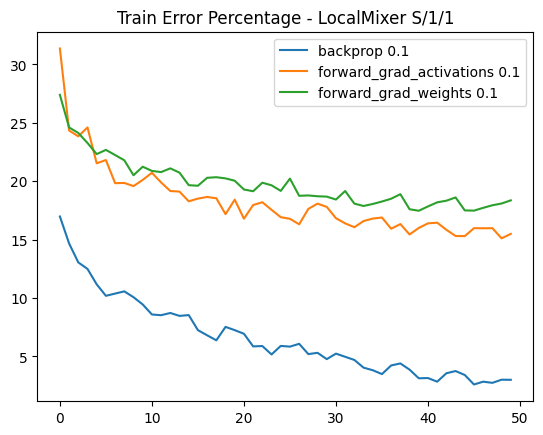

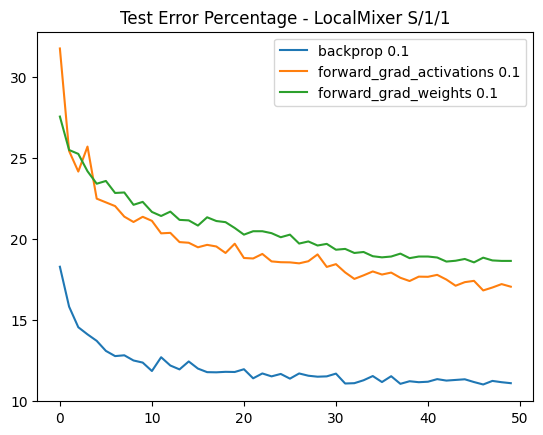

In [15]:
TYPE_BLOCK = "LocalMixer S/1/1"

DATASET = "fashion_mnist"

NUM_BLOCKS = 1                                # 4 from the paper
NUM_PATCHES = 1                               # 8x8
NUM_CHANNEL_MLP_UNITS = 256                  # from the paper
NUM_CHANNEL_MLP_HIDDEN_UNITS = -1 
NUM_GROUPS = 1                                 # 1

DOWNSAMPLE = "1"                              # "1,1,1,1"
CHANNEL_RATIO = "1"                           # "1,1,1,1"
GROUP_RATIO = "1"                             # "1,1,1,1"

FNAME = str(DATASET) + "_p" + str(NUM_PATCHES) + "_g" + str(NUM_GROUPS)
md = get_dataset_metadata(DATASET)
downsample = [int(d) for d in DOWNSAMPLE.split(",")]
channel_ratio = [int(d) for d in CHANNEL_RATIO.split(",")]
group_ratio = [int(d) for d in GROUP_RATIO.split(",")]
layer_sizes = get_layer_sizes(
    md,
    NUM_PATCHES,
    NUM_CHANNEL_MLP_UNITS,
    NUM_BLOCKS,
    NUM_GROUPS,
    CONCAT_GROUPS,
    SAME_HEAD,
    CONV_MIXER,
    KERNEL_SIZE,
    num_channel_mlp_hidden_units=NUM_CHANNEL_MLP_HIDDEN_UNITS,
    downsample=downsample,
    channel_ratio=channel_ratio,
    group_ratio=group_ratio,
)

param_scale = get_param_scale(INIT_SCHEME, layer_sizes)
# print("param scale", param_scale)
num_epochs = NUM_EPOCHS
experiment = EXPERIMENT_LIST


type_block = TYPE_BLOCK
blocks = NUM_BLOCKS
patches = NUM_PATCHES
channels = NUM_CHANNEL_MLP_UNITS
groups = NUM_GROUPS
params = None  # Not specified in the dictionary
dataset = DATASET


table = PrettyTable()
table.field_names = ["Type", "Blocks", "Patches", "Channels", "Groups", "Params", "Dataset"]
table.add_row([type_block, blocks, patches, channels, groups, params, dataset])

print(table)

train_loader = get_dataset("train", seed=0)

if TRAIN_EVAL:
    train_eval_loader = get_dataset("train_eval", seed=1)
else:
    train_eval_loader = None
test_loader = get_dataset("test", seed=0)

fname = FNAME
exp_dir = WORKING_DIR + "_" + fname
fname_full = f"{exp_dir}/results.pkl"

if experiment == "all":
    keys = [
        "backprop",
        "forward_grad_weights",
        "forward_grad_activations",
    ]
    lr_list = [float(s) for s in LR.split(",")]
    all_results = {}
    for mode in keys:
        all_results[mode] = {}
        log_dir = f"{exp_dir}/{mode}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                mode,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            all_results[mode][lr] = results
    if jax.process_index() == 0:
        pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))
else:
    exp_list = experiment.split(",")
    lr_list = [float(s) for s in LR.split(",")]
    for exp in exp_list:
        log_dir = f"{exp_dir}/{exp}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            print(lr)
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                exp,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            if tf.io.gfile.exists(fname_full):
                all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
            else:
                all_results = {}
            if exp not in all_results:
                all_results[exp] = {}
            all_results[exp][lr] = results
            if jax.process_index() == 0:
                pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))

# print(table)
import prettytable as pt
import pickle as pkl

# Load the results from the pickle file
all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))

# print(all_results)

# Create the table and add the header row
table = pt.PrettyTable(['Model', 'Blocks', 'Patches', 'Channels', 'Groups', 'Params', 'Dataset', 'Experiment, LR', 'Train Error (%)', 'Test Error (%)'])

# Loop through the types of experiments
for exp_type in all_results:
    # Loop through the LR values
    for lr in all_results[exp_type]:
        # Extract the final test and train error for this LR value
        test_error = (1 - all_results[exp_type][lr]['test_acc'][-1]) * 100
        train_error = (1 - all_results[exp_type][lr]['train_acc'][-1]) * 100
        # Add the errors to the table
        table.add_row([type_block, blocks, patches, channels, groups, params, dataset, f'{exp_type}, {lr}', f'{train_error:.2f} %', f'{test_error:.2f} %'])

# Print the table
print(table)
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        train_err_percentage = [(1-acc)*100 for acc in result["train_acc"]]
        plt.plot(train_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Train Error Percentage - " + type_block)
plt.savefig(f"{exp_dir}/train_err_percentage.png")
plt.show()

plt.close()
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        test_err_percentage = [(1-acc)*100 for acc in result["test_acc"]]
        plt.plot(test_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Test Error Percentage - " + type_block)
plt.savefig(f"{exp_dir}/test_err_percentage.png")
plt.show()
plt.close()

## LocalMixer S/1/1 - MNIST

In [16]:
TYPE_BLOCK = "LocalMixer S/1/1"

DATASET = "mnist"

NUM_BLOCKS = 1                                # 4 from the paper
NUM_PATCHES = 1
NUM_CHANNEL_MLP_UNITS = 256                  # from the paper
NUM_CHANNEL_MLP_HIDDEN_UNITS = -1 
NUM_GROUPS = 1  

FNAME = str(DATASET) + "_p" + str(NUM_PATCHES) + "_g" + str(NUM_GROUPS)

In [17]:
md = get_dataset_metadata(DATASET)
downsample = [int(d) for d in DOWNSAMPLE.split(",")]
channel_ratio = [int(d) for d in CHANNEL_RATIO.split(",")]
group_ratio = [int(d) for d in GROUP_RATIO.split(",")]
layer_sizes = get_layer_sizes(
    md,
    NUM_PATCHES,
    NUM_CHANNEL_MLP_UNITS,
    NUM_BLOCKS,
    NUM_GROUPS,
    CONCAT_GROUPS,
    SAME_HEAD,
    CONV_MIXER,
    KERNEL_SIZE,
    num_channel_mlp_hidden_units=NUM_CHANNEL_MLP_HIDDEN_UNITS,
    downsample=downsample,
    channel_ratio=channel_ratio,
    group_ratio=group_ratio,
)

param_scale = get_param_scale(INIT_SCHEME, layer_sizes)
# print("param scale", param_scale)
num_epochs = NUM_EPOCHS
experiment = EXPERIMENT_LIST

type_block = TYPE_BLOCK

blocks = NUM_BLOCKS
patches = NUM_PATCHES
channels = NUM_CHANNEL_MLP_UNITS
groups = NUM_GROUPS
params = None  # Not specified in the dictionary
dataset = DATASET


table = PrettyTable()
table.field_names = ["Type", "Blocks", "Patches", "Channels", "Groups", "Params", "Dataset"]
table.add_row([type_block, blocks, patches, channels, groups, params, dataset])

print(table)


+------------------+--------+---------+----------+--------+--------+---------+
|       Type       | Blocks | Patches | Channels | Groups | Params | Dataset |
+------------------+--------+---------+----------+--------+--------+---------+
| LocalMixer S/1/1 |   1    |    1    |   256    |   1    |  None  |  mnist  |
+------------------+--------+---------+----------+--------+--------+---------+


### train


In [18]:
train_loader = get_dataset("train", seed=0)

if TRAIN_EVAL:
    train_eval_loader = get_dataset("train_eval", seed=1)
else:
    train_eval_loader = None
test_loader = get_dataset("test", seed=0)

fname = FNAME
exp_dir = WORKING_DIR + "_" + fname
fname_full = f"{exp_dir}/results.pkl"

if experiment == "all":
    keys = [
        "backprop",
        "forward_grad_weights",
        "forward_grad_activations",
    ]
    lr_list = [float(s) for s in LR.split(",")]
    all_results = {}
    for mode in keys:
        all_results[mode] = {}
        log_dir = f"{exp_dir}/{mode}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                mode,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            all_results[mode][lr] = results
    if jax.process_index() == 0:
        pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))
else:
    exp_list = experiment.split(",")
    lr_list = [float(s) for s in LR.split(",")]
    for exp in exp_list:
        log_dir = f"{exp_dir}/{exp}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            # print('Learning Rate: ', lr)
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                exp,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            if tf.io.gfile.exists(fname_full):
                all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
            else:
                all_results = {}
            if exp not in all_results:
                all_results[exp] = {}
            all_results[exp][lr] = results
            if jax.process_index() == 0:
                pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))

# print(table)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Mode backprop LR 1.00e-01 Epoch 0 Time 9.10s Train Loss 0.71 Train Acc 91.80% Test Acc 91.73%
Mode backprop LR 9.80e-02 Epoch 1 Time 3.98s Train Loss 0.25 Train Acc 94.07% Test Acc 93.89%
Mode backprop LR 9.60e-02 Epoch 2 Time 4.03s Train Loss 0.19 Train Acc 95.06% Test Acc 94.96%
Mode backprop LR 9.40e-02 Epoch 3 Time 4.29s Train Loss 0.16 Train Acc 96.25% Test Acc 95.79%
Mode backprop LR 9.20e-02 Epoch 4 Time 4.37s Train Loss 0.13 Train Acc 96.75% Test Acc 96.18%
Mode backprop LR 9.00e-02 Epoch 5 Time 4.15s Train Loss 0.11 Train Acc 97.59% Test Acc 96.54%
Mode backprop LR 8.80e-02 Epoch 6 Time 4.11s Train Loss 0.10 Train Acc 97.57% Test Acc 96.85%
Mode backprop LR 8.60e-02 Epoch 7 Time 4.28s Train Loss 0.09 Train Acc 98.00% Test Acc 96.90%
Mode backprop LR 8.40e-02 Epoch 8 Time 4.25s Train Loss 0.08 Train Acc 98.07% Test Acc 97.24%
Mode backprop LR 8.20e-02 Epoch 9 Time 4.02s Train L

### execute

In [19]:
import prettytable as pt
import pickle as pkl

# Load the results from the pickle file
all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))

# # print(all_results)

# # Define the experiment parameters
# type_block = "LocalMixer S/1/1"
# blocks = NUM_BLOCKS
# patches = NUM_PATCHES
# channels = NUM_CHANNEL_MLP_UNITS
# groups = NUM_GROUPS
# params = None  # Not specified in the dictionary
# dataset = DATASET

# Create the table and add the header row
table = pt.PrettyTable(['Model', 'Blocks', 'Patches', 'Channels', 'Groups', 'Params', 'Dataset', 'Experiment, LR', 'Train Error (%)', 'Test Error (%)'])

# Loop through the types of experiments
for exp_type in all_results:
    # Loop through the LR values
    for lr in all_results[exp_type]:
        # Extract the final test and train error for this LR value
        test_error = (1 - all_results[exp_type][lr]['test_acc'][-1]) * 100
        train_error = (1 - all_results[exp_type][lr]['train_acc'][-1]) * 100
        # Add the errors to the table
        table.add_row([type_block, blocks, patches, channels, groups, params, dataset, f'{exp_type}, {lr}', f'{train_error:.2f} %', f'{test_error:.2f} %'])

# Print the table
print(table)

+------------------+--------+---------+----------+--------+--------+---------+-------------------------------+-----------------+----------------+
|      Model       | Blocks | Patches | Channels | Groups | Params | Dataset |         Experiment, LR        | Train Error (%) | Test Error (%) |
+------------------+--------+---------+----------+--------+--------+---------+-------------------------------+-----------------+----------------+
| LocalMixer S/1/1 |   1    |    1    |   256    |   1    |  None  |  mnist  |         backprop, 0.1         |      0.04 %     |     2.00 %     |
| LocalMixer S/1/1 |   1    |    1    |   256    |   1    |  None  |  mnist  |   forward_grad_weights, 0.1   |      9.47 %     |     9.18 %     |
| LocalMixer S/1/1 |   1    |    1    |   256    |   1    |  None  |  mnist  | forward_grad_activations, 0.1 |      4.03 %     |     4.62 %     |
+------------------+--------+---------+----------+--------+--------+---------+-------------------------------+--------------

## Results and Plots

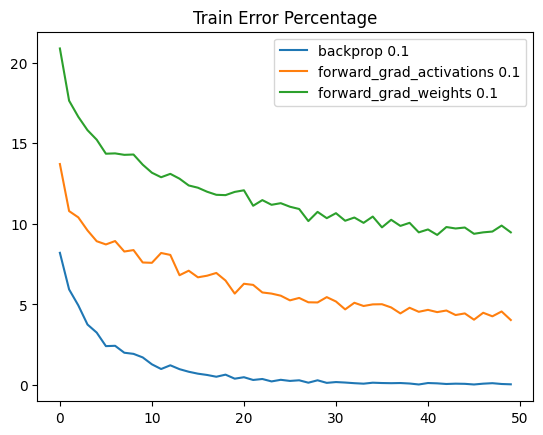

In [20]:
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        train_err_percentage = [(1-acc)*100 for acc in result["train_acc"]]
        plt.plot(train_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Train Error Percentage")
plt.savefig(f"{exp_dir}/train_err_percentage.png")
plt.show()

plt.close()


In [21]:
# all_results

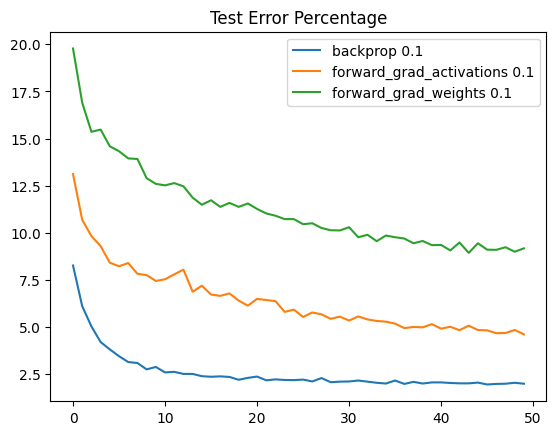

In [22]:
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        test_err_percentage = [(1-acc)*100 for acc in result["test_acc"]]
        plt.plot(test_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Test Error Percentage")
plt.savefig(f"{exp_dir}/test_err_percentage.png")
plt.show()
plt.close()


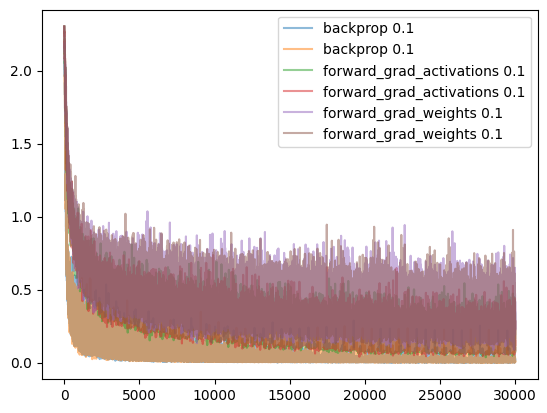

In [23]:
# loss
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        plt.plot(result["loss"], alpha=0.5, label=f"{key} {lr}")
plt.legend()
plt.savefig(f"{exp_dir}/loss.png")
plt.show()
plt.close()

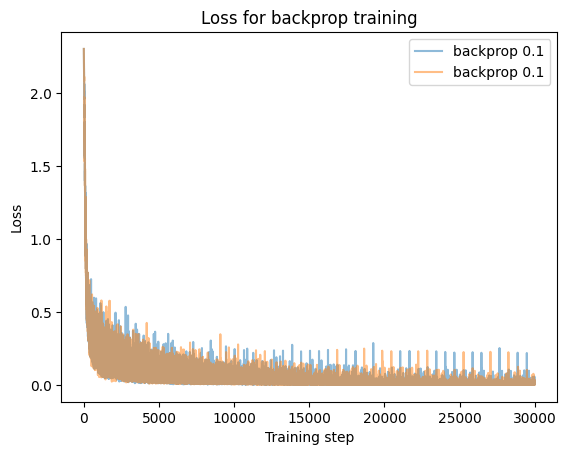

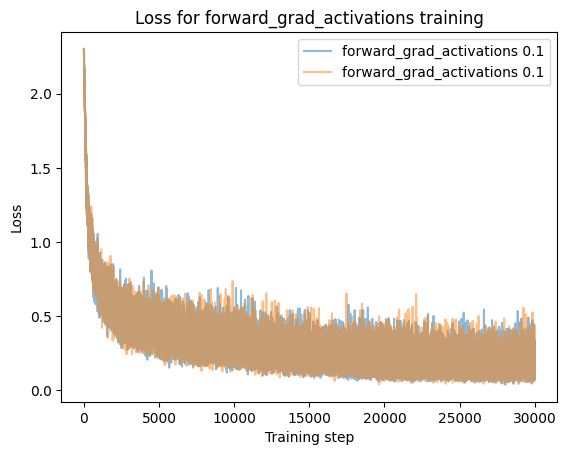

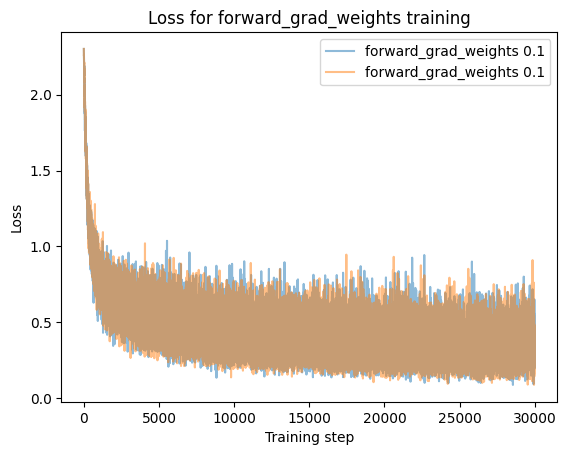

In [24]:
# plot losses for each training setting
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        plt.plot(result["loss"], alpha=0.5, label=f"{key} {lr}")
    plt.title(f"Loss for {key} training")
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{exp_dir}/{key}_loss.png")
    plt.show()
    plt.close()


In [25]:
# import matplotlib.pyplot as plt

# num_steps = num_epochs * num_batches
# losses = []
# for step in range(num_steps):
#     # train for one step
#     loss, local_losses, _ = loss(params, next(train_loader), key=key)
#     losses.append(loss)

# plt.plot(range(num_steps), losses)
# plt.xlabel('Training step')
# plt.ylabel('Loss')
# plt.show()


# LocalMixer M/1/16

In [26]:
TYPE_BLOCK = "LocalMixer M/1/16"

DATASET = "mnist"

NUM_BLOCKS = 1                                # 4 from the paper
NUM_PATCHES = 1
NUM_CHANNEL_MLP_UNITS = 512                  # from the paper
NUM_CHANNEL_MLP_HIDDEN_UNITS = -1 
NUM_GROUPS = 16                                                           # 1

FNAME = str(DATASET) + "_p" + str(NUM_PATCHES) + "_g" + str(NUM_GROUPS)

In [27]:
md = get_dataset_metadata(DATASET)
downsample = [int(d) for d in DOWNSAMPLE.split(",")]
channel_ratio = [int(d) for d in CHANNEL_RATIO.split(",")]
group_ratio = [int(d) for d in GROUP_RATIO.split(",")]
layer_sizes = get_layer_sizes(
    md,
    NUM_PATCHES,
    NUM_CHANNEL_MLP_UNITS,
    NUM_BLOCKS,
    NUM_GROUPS,
    CONCAT_GROUPS,
    SAME_HEAD,
    CONV_MIXER,
    KERNEL_SIZE,
    num_channel_mlp_hidden_units=NUM_CHANNEL_MLP_HIDDEN_UNITS,
    downsample=downsample,
    channel_ratio=channel_ratio,
    group_ratio=group_ratio,
)

param_scale = get_param_scale(INIT_SCHEME, layer_sizes)
# print("param scale", param_scale)
num_epochs = NUM_EPOCHS
experiment = EXPERIMENT_LIST


type_block = TYPE_BLOCK
blocks = NUM_BLOCKS
patches = NUM_PATCHES
channels = NUM_CHANNEL_MLP_UNITS
groups = NUM_GROUPS
params = None  # Not specified in the dictionary
dataset = DATASET


table = PrettyTable()
table.field_names = ["Type", "Blocks", "Patches", "Channels", "Groups", "Params", "Dataset"]
table.add_row([type_block, blocks, patches, channels, groups, params, dataset])

print(table)


+-------------------+--------+---------+----------+--------+--------+---------+
|        Type       | Blocks | Patches | Channels | Groups | Params | Dataset |
+-------------------+--------+---------+----------+--------+--------+---------+
| LocalMixer M/1/16 |   1    |    1    |   512    |   16   |  None  |  mnist  |
+-------------------+--------+---------+----------+--------+--------+---------+


In [28]:
train_loader = get_dataset("train", seed=0)

if TRAIN_EVAL:
    train_eval_loader = get_dataset("train_eval", seed=1)
else:
    train_eval_loader = None
test_loader = get_dataset("test", seed=0)

fname = FNAME
exp_dir = WORKING_DIR + "_" + fname
fname_full = f"{exp_dir}/results.pkl"

if experiment == "all":
    keys = [
        "backprop",
        "forward_grad_weights",
        "forward_grad_activations",
    ]
    lr_list = [float(s) for s in LR.split(",")]
    all_results = {}
    for mode in keys:
        all_results[mode] = {}
        log_dir = f"{exp_dir}/{mode}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                mode,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            all_results[mode][lr] = results
    if jax.process_index() == 0:
        pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))
else:
    exp_list = experiment.split(",")
    lr_list = [float(s) for s in LR.split(",")]
    for exp in exp_list:
        log_dir = f"{exp_dir}/{exp}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            print(lr)
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                exp,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            if tf.io.gfile.exists(fname_full):
                all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
            else:
                all_results = {}
            if exp not in all_results:
                all_results[exp] = {}
            all_results[exp][lr] = results
            if jax.process_index() == 0:
                pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))

# print(table)

0.1
Mode backprop LR 1.00e-01 Epoch 0 Time 8.32s Train Loss 0.62 Train Acc 91.87% Test Acc 92.43%
Mode backprop LR 9.80e-02 Epoch 1 Time 3.83s Train Loss 0.24 Train Acc 94.34% Test Acc 94.14%
Mode backprop LR 9.60e-02 Epoch 2 Time 3.93s Train Loss 0.18 Train Acc 95.38% Test Acc 95.09%
Mode backprop LR 9.40e-02 Epoch 3 Time 3.80s Train Loss 0.15 Train Acc 96.41% Test Acc 95.77%
Mode backprop LR 9.20e-02 Epoch 4 Time 4.60s Train Loss 0.12 Train Acc 96.97% Test Acc 96.15%
Mode backprop LR 9.00e-02 Epoch 5 Time 4.04s Train Loss 0.11 Train Acc 97.82% Test Acc 96.60%
Mode backprop LR 8.80e-02 Epoch 6 Time 4.06s Train Loss 0.09 Train Acc 97.71% Test Acc 96.99%
Mode backprop LR 8.60e-02 Epoch 7 Time 3.98s Train Loss 0.08 Train Acc 98.10% Test Acc 96.94%
Mode backprop LR 8.40e-02 Epoch 8 Time 3.95s Train Loss 0.08 Train Acc 98.26% Test Acc 97.11%
Mode backprop LR 8.20e-02 Epoch 9 Time 3.88s Train Loss 0.07 Train Acc 98.63% Test Acc 97.14%
Mode backprop LR 8.00e-02 Epoch 10 Time 3.90s Train Loss

In [29]:
import prettytable as pt
import pickle as pkl

# Load the results from the pickle file
all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))

# print(all_results)

# Create the table and add the header row
table = pt.PrettyTable(['Model', 'Blocks', 'Patches', 'Channels', 'Groups', 'Params', 'Dataset', 'Experiment, LR', 'Train Error (%)', 'Test Error (%)'])

# Loop through the types of experiments
for exp_type in all_results:
    # Loop through the LR values
    for lr in all_results[exp_type]:
        # Extract the final test and train error for this LR value
        test_error = (1 - all_results[exp_type][lr]['test_acc'][-1]) * 100
        train_error = (1 - all_results[exp_type][lr]['train_acc'][-1]) * 100
        # Add the errors to the table
        table.add_row([type_block, blocks, patches, channels, groups, params, dataset, f'{exp_type}, {lr}', f'{train_error:.2f} %', f'{test_error:.2f} %'])

# Print the table
print(table)

+-------------------+--------+---------+----------+--------+--------+---------+-------------------------------+-----------------+----------------+
|       Model       | Blocks | Patches | Channels | Groups | Params | Dataset |         Experiment, LR        | Train Error (%) | Test Error (%) |
+-------------------+--------+---------+----------+--------+--------+---------+-------------------------------+-----------------+----------------+
| LocalMixer M/1/16 |   1    |    1    |   512    |   16   |  None  |  mnist  |         backprop, 0.1         |      0.07 %     |     2.12 %     |
| LocalMixer M/1/16 |   1    |    1    |   512    |   16   |  None  |  mnist  |   forward_grad_weights, 0.1   |      6.22 %     |     6.61 %     |
| LocalMixer M/1/16 |   1    |    1    |   512    |   16   |  None  |  mnist  | forward_grad_activations, 0.1 |      1.06 %     |     2.54 %     |
+-------------------+--------+---------+----------+--------+--------+---------+-------------------------------+-------

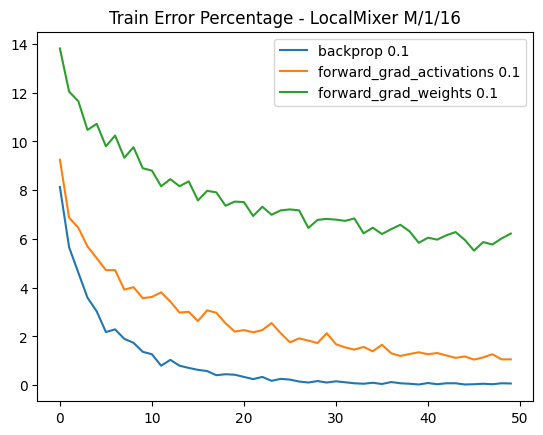

In [30]:
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        train_err_percentage = [(1-acc)*100 for acc in result["train_acc"]]
        plt.plot(train_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Train Error Percentage - " + type_block)
plt.savefig(f"{exp_dir}/train_err_percentage.png")
plt.show()

plt.close()

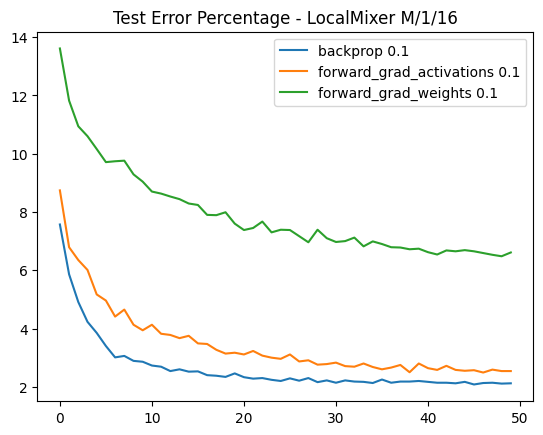

In [31]:
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        test_err_percentage = [(1-acc)*100 for acc in result["test_acc"]]
        plt.plot(test_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Test Error Percentage - " + type_block)
plt.savefig(f"{exp_dir}/test_err_percentage.png")
plt.show()
plt.close()

# LocalMixer M/8/16

In [32]:
def preprocess(view, image_mean, image_std, num_patches):
    patch_size = view.shape[1] // num_patches
    view = normalize_images(view, image_mean, image_std)
    # print(view)
    view = jnp.reshape(
        view,
        [
            view.shape[0],
            num_patches,
            patch_size,
            num_patches,
            patch_size,
            view.shape[3],
        ],
    )
    view = einops.rearrange(view, "n p h q w c -> n (p q) (h w c)")
    return view


In [33]:
TYPE_BLOCK = "LocalMixer M/8/16"
DATASET = "cifar-10"

NUM_BLOCKS = 4                               # 4 from the paper
NUM_PATCHES = 8                              # 8x8
NUM_CHANNEL_MLP_UNITS = 512                  # from the paper
NUM_CHANNEL_MLP_HIDDEN_UNITS = -1 
NUM_GROUPS = 16                                   # 1


DOWNSAMPLE = "1,1,1,1"
CHANNEL_RATIO = "1,1,1,1"
GROUP_RATIO = "1,1,1,1"

FNAME = str(DATASET) + "_p" + str(NUM_PATCHES) + "_g" + str(NUM_GROUPS)

In [34]:
md = get_dataset_metadata(DATASET)
downsample = [int(d) for d in DOWNSAMPLE.split(",")]
channel_ratio = [int(d) for d in CHANNEL_RATIO.split(",")]
group_ratio = [int(d) for d in GROUP_RATIO.split(",")]
layer_sizes = get_layer_sizes(
    md,
    NUM_PATCHES,
    NUM_CHANNEL_MLP_UNITS,
    NUM_BLOCKS,
    NUM_GROUPS,
    CONCAT_GROUPS,
    SAME_HEAD,
    CONV_MIXER,
    KERNEL_SIZE,
    num_channel_mlp_hidden_units=NUM_CHANNEL_MLP_HIDDEN_UNITS,
    downsample=downsample,
    channel_ratio=channel_ratio,
    group_ratio=group_ratio,
)

param_scale = get_param_scale(INIT_SCHEME, layer_sizes)
# print("param scale", param_scale)
num_epochs = NUM_EPOCHS
experiment = EXPERIMENT_LIST


type_block = TYPE_BLOCK
blocks = NUM_BLOCKS
patches = NUM_PATCHES
channels = NUM_CHANNEL_MLP_UNITS
groups = NUM_GROUPS
params = None  # Not specified in the dictionary
dataset = DATASET


table = PrettyTable()
table.field_names = ["Type", "Blocks", "Patches", "Channels", "Groups", "Params", "Dataset"]
table.add_row([type_block, blocks, patches, channels, groups, params, dataset])

print(table)


+-------------------+--------+---------+----------+--------+--------+----------+
|        Type       | Blocks | Patches | Channels | Groups | Params | Dataset  |
+-------------------+--------+---------+----------+--------+--------+----------+
| LocalMixer M/8/16 |   4    |    8    |   512    |   16   |  None  | cifar-10 |
+-------------------+--------+---------+----------+--------+--------+----------+


In [35]:
train_loader = get_dataset("train", seed=0)

if TRAIN_EVAL:
    train_eval_loader = get_dataset("train_eval", seed=1)
else:
    train_eval_loader = None
test_loader = get_dataset("test", seed=0)

fname = FNAME
exp_dir = WORKING_DIR + "_" + fname
fname_full = f"{exp_dir}/results.pkl"

if experiment == "all":
    keys = [
        "backprop",
        "forward_grad_weights",
        "forward_grad_activations",
    ]
    lr_list = [float(s) for s in LR.split(",")]
    all_results = {}
    for mode in keys:
        all_results[mode] = {}
        log_dir = f"{exp_dir}/{mode}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                mode,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            all_results[mode][lr] = results
    if jax.process_index() == 0:
        pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))
else:
    exp_list = experiment.split(",")
    lr_list = [float(s) for s in LR.split(",")]
    for exp in exp_list:
        log_dir = f"{exp_dir}/{exp}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            print(lr)
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                exp,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            if tf.io.gfile.exists(fname_full):
                all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
            else:
                all_results = {}
            if exp not in all_results:
                all_results[exp] = {}
            all_results[exp][lr] = results
            if jax.process_index() == 0:
                pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))

# print(table)

0.1


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling datasets/cifar10/3.0.2.incompleteF0OETM/cifar10-train.tfrecord*...:   0%|          | 0/50000 [00:00<…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling datasets/cifar10/3.0.2.incompleteF0OETM/cifar10-test.tfrecord*...:   0%|          | 0/10000 [00:00<?…

Dataset cifar10 downloaded and prepared to datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
Mode backprop LR 1.00e-01 Epoch 0 Time 77.82s Train Loss 2.04 Train Acc 34.64% Test Acc 35.17%
Mode backprop LR 9.80e-02 Epoch 1 Time 8.08s Train Loss 1.65 Train Acc 43.46% Test Acc 43.42%
Mode backprop LR 9.60e-02 Epoch 2 Time 7.90s Train Loss 1.39 Train Acc 51.48% Test Acc 50.55%
Mode backprop LR 9.40e-02 Epoch 3 Time 8.29s Train Loss 1.28 Train Acc 58.97% Test Acc 56.63%
Mode backprop LR 9.20e-02 Epoch 4 Time 7.99s Train Loss 1.19 Train Acc 58.49% Test Acc 55.26%
Mode backprop LR 9.00e-02 Epoch 5 Time 8.04s Train Loss 1.11 Train Acc 62.11% Test Acc 58.78%
Mode backprop LR 8.80e-02 Epoch 6 Time 8.26s Train Loss 1.05 Train Acc 63.77% Test Acc 60.93%
Mode backprop LR 8.60e-02 Epoch 7 Time 7.84s Train Loss 0.99 Train Acc 67.03% Test Acc 62.77%
Mode backprop LR 8.40e-02 Epoch 8 Time 7.95s Train Loss 0.94 Train Acc 67.18% Test Acc 61.06%
Mode backprop LR 8.20e-02 Epoch 9 Time 8.20s Tr

In [36]:
import prettytable as pt
import pickle as pkl

# Load the results from the pickle file
all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))

# print(all_results)

# Create the table and add the header row
table = pt.PrettyTable(['Model', 'Blocks', 'Patches', 'Channels', 'Groups', 'Params', 'Dataset', 'Experiment, LR', 'Train Error (%)', 'Test Error (%)'])

# Loop through the types of experiments
for exp_type in all_results:
    # Loop through the LR values
    for lr in all_results[exp_type]:
        # Extract the final test and train error for this LR value
        test_error = (1 - all_results[exp_type][lr]['test_acc'][-1]) * 100
        train_error = (1 - all_results[exp_type][lr]['train_acc'][-1]) * 100
        # Add the errors to the table
        table.add_row([type_block, blocks, patches, channels, groups, params, dataset, f'{exp_type}, {lr}', f'{train_error:.2f} %', f'{test_error:.2f} %'])

# Print the table
print(table)

+-------------------+--------+---------+----------+--------+--------+----------+-------------------------------+-----------------+----------------+
|       Model       | Blocks | Patches | Channels | Groups | Params | Dataset  |         Experiment, LR        | Train Error (%) | Test Error (%) |
+-------------------+--------+---------+----------+--------+--------+----------+-------------------------------+-----------------+----------------+
| LocalMixer M/8/16 |   4    |    8    |   512    |   16   |  None  | cifar-10 |         backprop, 0.1         |      0.26 %     |    32.06 %     |
| LocalMixer M/8/16 |   4    |    8    |   512    |   16   |  None  | cifar-10 |   forward_grad_weights, 0.1   |     61.57 %     |    61.73 %     |
| LocalMixer M/8/16 |   4    |    8    |   512    |   16   |  None  | cifar-10 | forward_grad_activations, 0.1 |     32.84 %     |    34.58 %     |
+-------------------+--------+---------+----------+--------+--------+----------+-------------------------------+

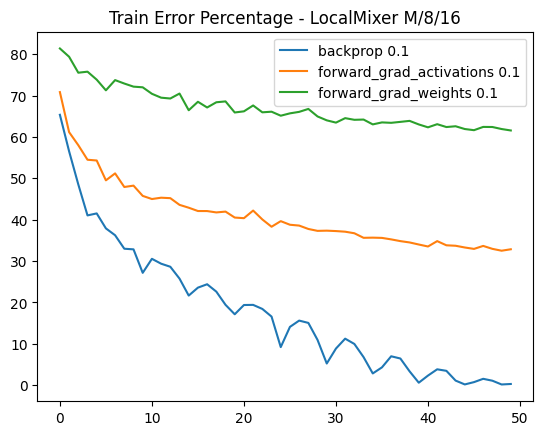

In [37]:
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        train_err_percentage = [(1-acc)*100 for acc in result["train_acc"]]
        plt.plot(train_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Train Error Percentage - " + type_block)
plt.savefig(f"{exp_dir}/train_err_percentage.png")
plt.show()

plt.close()

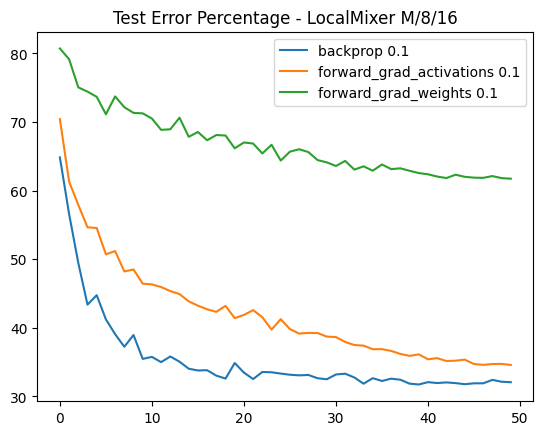

In [38]:
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        test_err_percentage = [(1-acc)*100 for acc in result["test_acc"]]
        plt.plot(test_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Test Error Percentage - " + type_block)
plt.savefig(f"{exp_dir}/test_err_percentage.png")
plt.show()
plt.close()

# LocalMixer M/8/64

In [39]:
TYPE_BLOCK = "LocalMixer M/8/64"

DATASET = "cifar-10"

NUM_BLOCKS = 4                                # 4 from the paper
NUM_PATCHES = 8                               # 8x8
NUM_CHANNEL_MLP_UNITS = 2048                  # from the paper
NUM_CHANNEL_MLP_HIDDEN_UNITS = -1 
NUM_GROUPS = 64                                                          # 1

FNAME = str(DATASET) + "_p" + str(NUM_PATCHES) + "_g" + str(NUM_GROUPS)

In [40]:
md = get_dataset_metadata(DATASET)
downsample = [int(d) for d in DOWNSAMPLE.split(",")]
channel_ratio = [int(d) for d in CHANNEL_RATIO.split(",")]
group_ratio = [int(d) for d in GROUP_RATIO.split(",")]
layer_sizes = get_layer_sizes(
    md,
    NUM_PATCHES,
    NUM_CHANNEL_MLP_UNITS,
    NUM_BLOCKS,
    NUM_GROUPS,
    CONCAT_GROUPS,
    SAME_HEAD,
    CONV_MIXER,
    KERNEL_SIZE,
    num_channel_mlp_hidden_units=NUM_CHANNEL_MLP_HIDDEN_UNITS,
    downsample=downsample,
    channel_ratio=channel_ratio,
    group_ratio=group_ratio,
)

param_scale = get_param_scale(INIT_SCHEME, layer_sizes)
# print("param scale", param_scale)
num_epochs = NUM_EPOCHS
experiment = EXPERIMENT_LIST


type_block = TYPE_BLOCK
blocks = NUM_BLOCKS
patches = NUM_PATCHES
channels = NUM_CHANNEL_MLP_UNITS
groups = NUM_GROUPS
params = None  # Not specified in the dictionary
dataset = DATASET


table = PrettyTable()
table.field_names = ["Type", "Blocks", "Patches", "Channels", "Groups", "Params", "Dataset"]
table.add_row([type_block, blocks, patches, channels, groups, params, dataset])

print(table)


+-------------------+--------+---------+----------+--------+--------+----------+
|        Type       | Blocks | Patches | Channels | Groups | Params | Dataset  |
+-------------------+--------+---------+----------+--------+--------+----------+
| LocalMixer M/8/64 |   4    |    8    |   2048   |   64   |  None  | cifar-10 |
+-------------------+--------+---------+----------+--------+--------+----------+


In [41]:
train_loader = get_dataset("train", seed=0)

if TRAIN_EVAL:
    train_eval_loader = get_dataset("train_eval", seed=1)
else:
    train_eval_loader = None
test_loader = get_dataset("test", seed=0)

fname = FNAME
exp_dir = WORKING_DIR + "_" + fname
fname_full = f"{exp_dir}/results.pkl"

if experiment == "all":
    keys = [
        "backprop",
        "forward_grad_weights",
        "forward_grad_activations",
    ]
    lr_list = [float(s) for s in LR.split(",")]
    all_results = {}
    for mode in keys:
        all_results[mode] = {}
        log_dir = f"{exp_dir}/{mode}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                mode,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            all_results[mode][lr] = results
    if jax.process_index() == 0:
        pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))
else:
    exp_list = experiment.split(",")
    lr_list = [float(s) for s in LR.split(",")]
    for exp in exp_list:
        log_dir = f"{exp_dir}/{exp}"
        if not tf.io.gfile.exists(log_dir):
            tf.io.gfile.makedirs(log_dir)
        for lr in lr_list:
            print(lr)
            lr_dir = "{}/{:.2e}".format(log_dir, lr)
            if not tf.io.gfile.exists(lr_dir):
                tf.io.gfile.makedirs(lr_dir)
            results = run_exp(
                exp,
                lr,
                train_loader,
                train_eval_loader,
                test_loader,
                param_scale,
                layer_sizes,
                num_epochs,
                lr_dir,
            )
            if tf.io.gfile.exists(fname_full):
                all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
            else:
                all_results = {}
            if exp not in all_results:
                all_results[exp] = {}
            all_results[exp][lr] = results
            if jax.process_index() == 0:
                pkl.dump(all_results, tf.io.gfile.GFile(fname_full, "wb"))

# print(table)

0.1
Mode backprop LR 1.00e-01 Epoch 0 Time 52.15s Train Loss 2.56 Train Acc 30.73% Test Acc 31.31%
Mode backprop LR 9.80e-02 Epoch 1 Time 46.18s Train Loss 1.75 Train Acc 46.06% Test Acc 46.07%
Mode backprop LR 9.60e-02 Epoch 2 Time 46.69s Train Loss 1.45 Train Acc 53.07% Test Acc 51.44%
Mode backprop LR 9.40e-02 Epoch 3 Time 46.87s Train Loss 1.32 Train Acc 61.04% Test Acc 57.41%
Mode backprop LR 9.20e-02 Epoch 4 Time 46.80s Train Loss 1.20 Train Acc 61.97% Test Acc 55.61%
Mode backprop LR 9.00e-02 Epoch 5 Time 46.86s Train Loss 1.10 Train Acc 62.78% Test Acc 58.53%
Mode backprop LR 8.80e-02 Epoch 6 Time 46.99s Train Loss 1.03 Train Acc 62.80% Test Acc 57.73%
Mode backprop LR 8.60e-02 Epoch 7 Time 46.98s Train Loss 0.95 Train Acc 70.44% Test Acc 63.65%
Mode backprop LR 8.40e-02 Epoch 8 Time 46.97s Train Loss 0.89 Train Acc 71.79% Test Acc 61.77%
Mode backprop LR 8.20e-02 Epoch 9 Time 46.96s Train Loss 0.84 Train Acc 77.23% Test Acc 63.02%
Mode backprop LR 8.00e-02 Epoch 10 Time 47.00s

In [42]:
import prettytable as pt
import pickle as pkl

# Load the results from the pickle file
all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))

# print(all_results)

# Create the table and add the header row
table = pt.PrettyTable(['Model', 'Blocks', 'Patches', 'Channels', 'Groups', 'Params', 'Dataset', 'Experiment, LR', 'Train Error (%)', 'Test Error (%)'])

# Loop through the types of experiments
for exp_type in all_results:
    # Loop through the LR values
    for lr in all_results[exp_type]:
        # Extract the final test and train error for this LR value
        test_error = (1 - all_results[exp_type][lr]['test_acc'][-1]) * 100
        train_error = (1 - all_results[exp_type][lr]['train_acc'][-1]) * 100
        # Add the errors to the table
        table.add_row([type_block, blocks, patches, channels, groups, params, dataset, f'{exp_type}, {lr}', f'{train_error:.2f} %', f'{test_error:.2f} %'])

# Print the table
print(table)

+-------------------+--------+---------+----------+--------+--------+----------+-------------------------------+-----------------+----------------+
|       Model       | Blocks | Patches | Channels | Groups | Params | Dataset  |         Experiment, LR        | Train Error (%) | Test Error (%) |
+-------------------+--------+---------+----------+--------+--------+----------+-------------------------------+-----------------+----------------+
| LocalMixer M/8/64 |   4    |    8    |   2048   |   64   |  None  | cifar-10 |         backprop, 0.1         |      0.00 %     |    32.03 %     |
| LocalMixer M/8/64 |   4    |    8    |   2048   |   64   |  None  | cifar-10 |   forward_grad_weights, 0.1   |     56.25 %     |    56.86 %     |
| LocalMixer M/8/64 |   4    |    8    |   2048   |   64   |  None  | cifar-10 | forward_grad_activations, 0.1 |     33.09 %     |    36.10 %     |
+-------------------+--------+---------+----------+--------+--------+----------+-------------------------------+

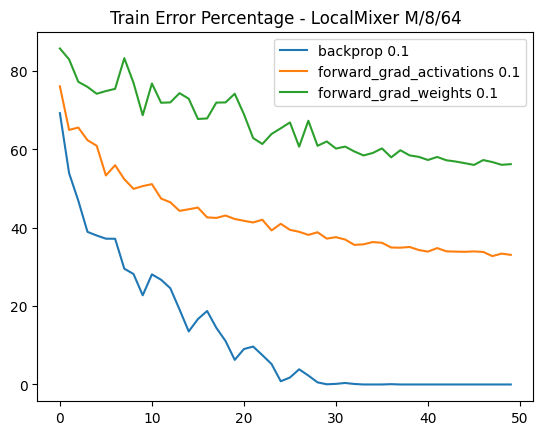

In [43]:
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        train_err_percentage = [(1-acc)*100 for acc in result["train_acc"]]
        plt.plot(train_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Train Error Percentage - " + type_block)
plt.savefig(f"{exp_dir}/train_err_percentage.png")
plt.show()

plt.close()

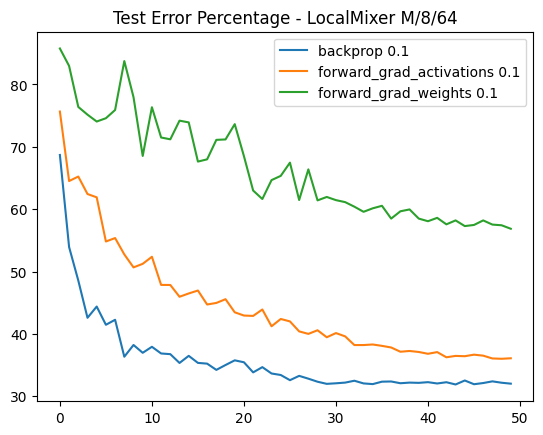

In [44]:
import matplotlib.pyplot as plt

all_results = pkl.load(tf.io.gfile.GFile(fname_full, "rb"))
# print(all_results)
keys = list(all_results.keys())
keys.sort()
for key in keys:
    results = all_results[key]
    lr_list = list(results.keys())
    lr_list.sort()
    for lr in lr_list:
        result = results[lr]
        test_err_percentage = [(1-acc)*100 for acc in result["test_acc"]]
        plt.plot(test_err_percentage, label=f"{key} {lr}")
plt.legend()
plt.title("Test Error Percentage - " + type_block)
plt.savefig(f"{exp_dir}/test_err_percentage.png")
plt.show()
plt.close()

In [45]:
!zip -r file.zip /kaggle/working
!ls
from IPython.display import FileLink
FileLink(r'file.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/experiments_mnist_p1_g1/ (stored 0%)
  adding: kaggle/working/experiments_mnist_p1_g1/test_err_percentage.png (deflated 6%)
  adding: kaggle/working/experiments_mnist_p1_g1/forward_grad_weights/ (stored 0%)
  adding: kaggle/working/experiments_mnist_p1_g1/forward_grad_weights/1.00e-01/ (stored 0%)
  adding: kaggle/working/experiments_mnist_p1_g1/forward_grad_weights/1.00e-01/ckpt-47 (deflated 7%)
  adding: kaggle/working/experiments_mnist_p1_g1/forward_grad_weights/1.00e-01/events.out.tfevents.1683474855.8404f8d96426.31.4.v2 (deflated 75%)
  adding: kaggle/working/experiments_mnist_p1_g1/forward_grad_weights/1.00e-01/ckpt-49 (deflated 7%)
  adding: kaggle/working/experiments_mnist_p1_g1/forward_grad_weights/1.00e-01/ckpt-48 (deflated 7%)
  adding: kaggle/working/experiments_mnist_p1_g1/loss.png (deflated 7%)
  adding: kaggle/working/experiments_mnist_p1_g1/backprop/ (stored 0%)
  adding: kaggle/working/experiments_mnist_p1_

/kaggle/working/file.zip

In [46]:
# import jax
# import jax.numpy as jnp
# from jax.scipy.special import logsumexp

# # No change in this function
# def _spatial_avg_group_linear_cross_entropy(x, w, b, labels):
#     N, P, G, C = x.shape
#     x_avg = jnp.mean(x, axis=1)
#     x_grp = jnp.reshape(x_avg, [x_avg.shape[0], -1])
#     logits = jnp.einsum('nc,cd->nd', x_grp, w) + b
#     logits = logits - logsumexp(logits, axis=-1, keepdims=True)
#     loss = -jnp.sum(logits * labels, axis=-1)
#     return jnp.tile(jnp.reshape(loss, [N, 1, 1]), [1, P, G])

# # No change in this function
# @jax.custom_vjp
# def spatial_avg_group_linear_cross_entropy_custom_vjp(x, w, b, labels):
#     return _spatial_avg_group_linear_cross_entropy(x, w, b, labels)

# # No change in this function
# @jax.custom_jvp
# def spatial_avg_group_linear_cross_entropy_custom_jvp(x, w, b, labels):
#     return _spatial_avg_group_linear_cross_entropy(x, w, b, labels)

# # Removed unnecessary functions and kept only the required ones
# spatial_avg_group_linear_cross_entropy_custom_jvp.defjvp(spatial_avg_group_linear_cross_entropy_jvp_)
# spatial_avg_group_linear_cross_entropy_custom_vjp.defvjp(spatial_avg_group_linear_cross_entropy_fwd_, spatial_avg_group_linear_cross_entropy_bwd_)

# # Rewrote the function, combining operations and simplifying the code
# def spatial_avg_group_linear_cross_entropy_v2(x, w, b, labels):
#     N, P, G, C = x.shape
    
#     # Combined and simplified the x transformation steps
#     x = jnp.tile(
#         jnp.reshape(
#             x / float(P) + jax.lax.stop_gradient(jnp.mean(x, axis=1, keepdims=True) - x / float(P)),
#             [N, P, 1, G, -1]
#         ),
#         [1, 1, G, 1, 1]
#     )
    
#     # Combined and simplified the mask and reshaping steps
#     x = jnp.reshape(
#         jnp.eye(G)[None, None, :, :, None] * x + jax.lax.stop_gradient((1.0 - jnp.eye(G)[None, None, :, :, None]) * x),
#         [N, P, G, -1]
#     )
    
#     # Kept the logits and loss calculation steps unchanged
#     logits = jnp.einsum('npgc,cd->npgd', x, w) + b
#     logits = logits - logsumexp(logits, axis=-1, keepdims=True)
#     loss = -jnp.sum(logits * labels[:, None, None, :], axis=-1)
#     return loss
